In [4]:
from typing import Union, List, Any, Optional, Dict

import os
import re
import time
import json
import glob
import pickle
import random
import urllib
import requests
import subprocess
import concurrent.futures

import numpy as np
import pandas as pd
import seaborn as sns

from bs4 import BeautifulSoup
from tqdm import tqdm
from pathlib import Path
from textblob import TextBlob
from threading import current_thread
from matplotlib import pyplot as plt
from collections import Counter
from transformers import BertTokenizer, BertModel
from gap_statistic import OptimalK
from sklearn.cluster import KMeans #, AgglomerativeClustering
from sklearn.neighbors import kneighbors_graph

try:
    from libKMCUDA import kmeans_cuda
except:
    print("KM cuda not found, defaulting to sklearn CPU version of kmeans")
    kmeans_cuda = None

from utils import cleaning_utils
from utils import cluster_utils
from utils import IDF_computation
from utils import embedding_utils as embedding
from utils.customdocument import CustomDocument

KM cuda not found, defaulting to sklearn CPU version of kmeans


<div class="alert alert-block alert-info"> 
We will run our term extraction on the Merged Approved Documents, the .pdf file can be found in the `data/` directory. For filtering of out-of-domain terms we will also process a set of EU regulations for medical device design, the .html files for these can be found in the same directory.
</div>

1. Preprocessing will consist only of removing headers/footers from PDF files. 

2. Candidate terms are identified using SPaR.txt (Kruiper et al., 2021), sentence splitting is done with the PunkSentTokenizer (Strunk, 2006).

3. Filtering of term candidates consists of:
  * a set of regular expressions found in utils.py
  * clustering of terms found in (1) the Approved Documents, and (2) a set of EU regulations for medical device design; any clusters containing terms from (2) will be designated as terms that are irrelevant to the AEC domain.
  
 


### 1 Preprocessing: get text from PDF and HTML

<div class="alert alert-block alert-info">
Here, we grab the text from our foreground and background corpora.
</div>


In [18]:
input_path = Path("data/input/")
output_dir = Path("data/converted_documents/")
output_dir.mkdir(parents=True, exist_ok=True) # create the converted_documents directory if needed

# NOTE: in our case the foreground corpus is the merged_approved_pdf_file, 
#       and the background corpus is a set of html files
merged_approved_pdf_file = [x for x in input_path.glob("*.pdf")][0]
eu_html_files = [x for x in input_path.glob("*.html")]

print(f"Approved Documents: {merged_approved_pdf_file}")
print(f"Reference corpus: {[str(x) for x in eu_html_files]}")

Approved Documents: data/input/The Merged Approved Documents.pdf
Reference corpus: ['data/input/EUR-Lex - 31993L0042 - EN.html', 'data/input/CELEX 32017R0746 EN TXT.html', 'data/input/CELEX 32017R0745 EN TXT.html', 'data/input/EUR-Lex - 31998L0079 - EN.html', 'data/input/EUR-Lex - 31990L0385 - EN.html']


In [6]:
merged_approved_pdf_file.exists()

True

<div class="alert alert-block alert-info">
First we grab the text from the Merged Approved Documents pdf file. Our implementation on based on the pdf conversion pipeline in Haystack.
</div>

In [13]:
def read_pdf(file_path: Path, layout: bool = True, encoding: Optional[str] = "Latin1") -> List[str]:
        """
        Extract pages from the pdf file at file_path; based on Haystack.

        :param file_path: path of the pdf file
        :param layout: whether to retain the original physical layout for a page. If disabled, PDF pages are read in
                       the content stream order.
        """
        if layout:
            command = ["pdftotext", "-enc", encoding, "-layout", str(file_path), "-"]
        else:
            command = ["pdftotext", "-enc", encoding, str(file_path), "-"]
        output = subprocess.run(command, stdout=subprocess.PIPE, shell=False)  # type: ignore
        document = output.stdout.decode(errors="ignore")
        pages = document.split("\f")
        pages = pages[:-1]  # the last page in the split is always empty.
        return pages

def convert_pdf_to_mydoc(source_file_path: Path, 
                         output_file_path: Path, 
                         meta: Optional[Dict[str, str]] = None,
                         remove_header_and_footer: Optional[bool] = True,
                         clean_whitespace: Optional[bool] = True,
                         clean_empty_lines: Optional[bool] = True,
                         encoding: Optional[str] = "Latin1") -> CustomDocument:
        """
        Extract pages from the pdf file at file_path; based on Haystack.

        :param output_file_path:    Path to the .json file to store the converted file.
        :param source_file_path:    Path to the .pdf file you want to convert
        :param meta: Optional dictionary with metadata that shall be attached to all resulting documents.
                     Can be any custom keys and values.
        :param encoding: Encoding that will be passed as -enc parameter to pdftotext. "Latin 1" is the default encoding
                         of pdftotext. While this works well on many PDFs, it might be needed to switch to "UTF-8" or
                         others if your doc contains special characters (e.g. German Umlauts, Cyrillic characters ...).
                         Note: With "UTF-8" we experienced cases, where a simple "fi" gets wrongly parsed as
                         "xef\xac\x81c" (see test cases). That's why we keep "Latin 1" as default here.
                         (See list of available encodings by running `pdftotext -listenc` in the terminal)
        """
        pages = read_pdf(source_file_path, layout=True, encoding=encoding)

        if not pages:
            # empty input file
            return None
        
        pages = ["\n".join(p.splitlines()) for p in pages]

        # splitting text happens during preprocessing, so no split_size passed here;
        # split_size will be set to -1 during conversion.
        document = CustomDocument(output_file_path, source_file_path, split_size=-1)
        
        print("Converted PDF file to pages of text, combining to a single CustomDocument to keep track of page nrs.")
        for page_idx, page in tqdm(enumerate(pages)):
            
            # some simple cleaning -- roughly based on haystack.
            lines = page.splitlines()
            if remove_header_and_footer:
                # simplest way for removing header and footer 
                lines = lines[1:-2]

            if clean_whitespace:
                cleaned_lines = []
                for line in lines:
                    line = line.strip()
                    cleaned_lines.append(line)
                text = " ".join(cleaned_lines)

            if clean_empty_lines:
                text = re.sub(r"\n\n+", "\n\n", text)
                text = re.sub(r"[\s]+", " ", text)
            
            # no splitting here yet, so simply using page_nr as a place holder and split_id is left blank
            page_nr = str(page_idx + 1)
            document.add_content(text=text, 
                                 page_nr=page_nr, 
                                 doc_title=source_file_path.name)   # we're using the pdf file name for simplicity

        return document

In [20]:
output_path = output_dir.joinpath("merged_approved.json")
merged_approved_document = convert_pdf_to_mydoc(merged_approved_pdf_file, output_path)

Converted PDF file to pages of text, combining to a single CustomDocument to keep track of page nrs.


1274it [00:00, 7145.14it/s]


In [15]:
print(f"Maximum character length for a single block of text: {max([len(c.text) for c in merged_approved_document.all_contents])}")

Maximum character length for a single block of text: 5537


In [31]:
sorted(merged_approved_pdf_file.parent.glob("*"))

[PosixPath('data/input/CELEX 32017R0745 EN TXT.html'),
 PosixPath('data/input/CELEX 32017R0746 EN TXT.html'),
 PosixPath('data/input/EUR-Lex - 31990L0385 - EN.html'),
 PosixPath('data/input/EUR-Lex - 31993L0042 - EN.html'),
 PosixPath('data/input/EUR-Lex - 31998L0079 - EN.html'),
 PosixPath('data/input/The Merged Approved Documents.pdf'),
 PosixPath('data/input/uniclass_2015.ttl'),
 PosixPath('data/input/uniclass_2015.ttl.json')]

<div class="alert alert-block alert-info">
Second, we grab the text from the EU regulation HTML files. Because the text in HTML files isn't split into pages, the blocks of text are much longer.
</div>

In [32]:
def grab_HTML_text_simple(file_path: Path):
    """
    All text in the EU htmls seems to be captured neatly in <p> tags, we don't care about structure currently.
    We do remove all unicode characters, see `utils.remove_unicode_chars()`.
    """ 
    with open(file_path, 'r') as f:
        text = f.read()
    soup = BeautifulSoup(text, 'html.parser')
    return [cleaning_utils.remove_unicode_chars(x.text) for x in soup.body.find_all('p')]

In [33]:
def convert_html_to_mydoc(source_file_path: Path, 
                          output_file_path: Path) -> CustomDocument:
    
    document = CustomDocument(output_file_path, source_file_path, split_size=-1)
    document_paragraphs = []
    list_of_paragraphs = grab_HTML_text_simple(source_file_path)
    for paragraph in list_of_paragraphs:
        if paragraph.strip() != '':
            document_paragraphs.append(paragraph)
    
    for paragraph_idx, paragraph in tqdm(enumerate(document_paragraphs)):
            # no splitting here yet, so simply using page_nr as a place holder and split_id is left blank
            paragraph_nr = str(paragraph_idx + 1)
            document.add_content(text=paragraph, 
                                 page_nr=paragraph_nr, 
                                 doc_title=source_file_path.name) # we're using the html file name for simplicity
    return document

In [34]:
eu_regulation_documents = []

for html_file in tqdm(eu_html_files):
    output_path = output_dir.joinpath(html_file.stem + ".json")
    eu_regulation_documents.append(convert_html_to_mydoc(html_file, output_path))


  0%|                                                                                                                                                                               | 0/5 [00:00<?, ?it/s]
826it [00:00, 243293.20it/s]

4344it [00:00, 294646.52it/s]
 40%|██████████████████████████████████████████████████████████████████▊                                                                                                    | 2/5 [00:01<00:01,  1.89it/s]
4799it [00:00, 333567.52it/s]
 60%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 3/5 [00:01<00:01,  1.49it/s]
623it [00:00, 306121.30it/s]

511it [00:00, 267676.95it/s]
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.51it/s]


In [35]:
print(f"Maximum character length for a single paragraph: {max([len(c.text) for d in eu_regulation_documents for c in d.all_contents])}")

Maximum character length for a single paragraph: 143428


<div class="alert alert-block alert-info">
Third, if the output document doesn't exist (yet), we save the ConvertedDocument.
</div>

In [36]:
foreground_corpus = [merged_approved_document]
background_corpus = eu_regulation_documents

In [37]:
for d in foreground_corpus + background_corpus:
    if not os.path.exists(d.output_fp):
        d.write_document()

### 2 Term extraction: identify object spans with SPaR.txt

<div class="alert alert-block alert-info">
For each of the sentences in our corpora, we run SPaR.txt for object identification.
</div>



In [43]:
# download SPaR.txt if required
spartxt_path = Path("SPaR.txt/")
if not spartxt_path.exists():
    !git clone https://github.com/rubenkruiper/SPaR.txt.git

Cloning into 'SPaR.txt'...
remote: Enumerating objects: 11856, done.
remote: Counting objects: 100% (2189/2189), done.
remote: Compressing objects: 100% (1147/1147), done.
remote: Total 11856 (delta 859), reused 2176 (delta 849), pack-reused 9667
Receiving objects: 100% (11856/11856), 4.84 MiB | 5.08 MiB/s, done.
Resolving deltas: 100% (1236/1236), done.
Updating files: 100% (14621/14621), done.


In [44]:
import imp
with open(spartxt_path.joinpath('spar_predictor.py'), 'rb') as fp:
    spar_predictor = imp.load_module(
        'spar_predictor', fp, 'SPaR.txt.spar_predictor.py',
        ('.py', 'rb', imp.PY_SOURCE)
    )

In [45]:
# trains a model if needed, otherwise loads from archive; 
# - best F1 on dev/validation in the paper is 80,96 trained on a GPU, CPU will be a bit lower ~77.x I think
sp = spar_predictor.SparPredictor()

No trained model found, creating one at /Users/rubenkruiper/dev/irec/term_extraction/SPaR.txt/trained_models/debugger_train. 
If a GPU is available, this will take several minutes. If no GPU is available, this will take 20+ minutes.


2023-01-13 10:04:53,341 - INFO - allennlp.common.params - evaluation = None
2023-01-13 10:04:53,343 - INFO - allennlp.common.params - include_in_archive = None


2023-01-13 10:04:53,344 - INFO - allennlp.common.params - random_seed = 13370
2023-01-13 10:04:53,345 - INFO - allennlp.common.params - numpy_seed = 1337
2023-01-13 10:04:53,345 - INFO - allennlp.common.params - pytorch_seed = 133
2023-01-13 10:04:53,362 - INFO - allennlp.common.checks - Pytorch version: 1.10.1
2023-01-13 10:04:53,363 - INFO - allennlp.common.params - type = default
2023-01-13 10:04:53,364 - INFO - allennlp.common.params - dataset_reader.type = tag_reader
2023-01-13 10:04:53,365 - INFO - allennlp.common.params - dataset_reader.max_instances = None
2023-01-13 10:04:53,365 - INFO - allennlp.common.params - dataset_reader.manual_distributed_sharding = False
2023-01-13 10:04:53,366 - INFO - allennlp.common.params - dataset_reader.manual_multiprocess_sharding = False
2023-01-13 10:04:53,367 - INFO - allennlp.common.params - dataset_reader.bert_model_name = bert-base-cased
2023-01-13 10:04:53,368 - INFO - allennlp.common.params - dataset_reader.token_indexers.tokens.type = p

loading instances: 0it [00:00, ?it/s]

2023-01-13 10:05:15,195 - INFO - allennlp.common.params - data_loader.type = multiprocess
2023-01-13 10:05:15,196 - INFO - allennlp.common.params - data_loader.batch_size = None
2023-01-13 10:05:15,196 - INFO - allennlp.common.params - data_loader.drop_last = False
2023-01-13 10:05:15,197 - INFO - allennlp.common.params - data_loader.shuffle = False
2023-01-13 10:05:15,198 - INFO - allennlp.common.params - data_loader.batch_sampler.type = bucket
2023-01-13 10:05:15,199 - INFO - allennlp.common.params - data_loader.batch_sampler.batch_size = 16
2023-01-13 10:05:15,200 - INFO - allennlp.common.params - data_loader.batch_sampler.sorting_keys = ['tokens']
2023-01-13 10:05:15,201 - INFO - allennlp.common.params - data_loader.batch_sampler.padding_noise = 0.1
2023-01-13 10:05:15,202 - INFO - allennlp.common.params - data_loader.batch_sampler.drop_last = False
2023-01-13 10:05:15,202 - INFO - allennlp.common.params - data_loader.batch_sampler.shuffle = True
2023-01-13 10:05:15,203 - INFO - al

loading instances: 0it [00:00, ?it/s]

2023-01-13 10:05:15,269 - INFO - allennlp.common.params - type = from_instances
2023-01-13 10:05:15,270 - INFO - allennlp.common.params - min_count = None
2023-01-13 10:05:15,270 - INFO - allennlp.common.params - max_vocab_size = None
2023-01-13 10:05:15,271 - INFO - allennlp.common.params - non_padded_namespaces = ('*tags', '*labels')
2023-01-13 10:05:15,272 - INFO - allennlp.common.params - pretrained_files = None
2023-01-13 10:05:15,272 - INFO - allennlp.common.params - only_include_pretrained_words = False
2023-01-13 10:05:15,273 - INFO - allennlp.common.params - tokens_to_add = None
2023-01-13 10:05:15,273 - INFO - allennlp.common.params - min_pretrained_embeddings = None
2023-01-13 10:05:15,274 - INFO - allennlp.common.params - padding_token = @@PADDING@@
2023-01-13 10:05:15,275 - INFO - allennlp.common.params - oov_token = @@UNKNOWN@@
2023-01-13 10:05:15,275 - INFO - allennlp.data.vocabulary - Fitting token dictionary from dataset.


building vocab: 0it [00:00, ?it/s]

2023-01-13 10:05:15,299 - INFO - allennlp.common.params - model.type = attention_tagger
2023-01-13 10:05:15,300 - INFO - allennlp.common.params - model.regularizer = None
2023-01-13 10:05:15,301 - INFO - allennlp.common.params - model.text_field_embedder.type = basic
2023-01-13 10:05:15,302 - INFO - allennlp.common.params - model.text_field_embedder.token_embedders.tokens.type = pretrained_transformer
2023-01-13 10:05:15,303 - INFO - allennlp.common.params - model.text_field_embedder.token_embedders.tokens.model_name = bert-base-cased
2023-01-13 10:05:15,304 - INFO - allennlp.common.params - model.text_field_embedder.token_embedders.tokens.max_length = 512
2023-01-13 10:05:15,305 - INFO - allennlp.common.params - model.text_field_embedder.token_embedders.tokens.sub_module = None
2023-01-13 10:05:15,306 - INFO - allennlp.common.params - model.text_field_embedder.token_embedders.tokens.train_parameters = False
2023-01-13 10:05:15,306 - INFO - allennlp.common.params - model.text_field_emb

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


2023-01-13 10:05:18,207 - INFO - allennlp.common.params - model.encoder.type = lstm
2023-01-13 10:05:18,208 - INFO - allennlp.common.params - model.encoder.input_size = 768
2023-01-13 10:05:18,209 - INFO - allennlp.common.params - model.encoder.hidden_size = 384
2023-01-13 10:05:18,210 - INFO - allennlp.common.params - model.encoder.num_layers = 1
2023-01-13 10:05:18,210 - INFO - allennlp.common.params - model.encoder.bias = True
2023-01-13 10:05:18,211 - INFO - allennlp.common.params - model.encoder.dropout = 0.0
2023-01-13 10:05:18,212 - INFO - allennlp.common.params - model.encoder.bidirectional = True
2023-01-13 10:05:18,212 - INFO - allennlp.common.params - model.encoder.stateful = False
2023-01-13 10:05:18,236 - INFO - allennlp.common.params - model.label_namespace = labels
2023-01-13 10:05:18,237 - INFO - allennlp.common.params - model.feedforward.input_dim = 1536
2023-01-13 10:05:18,237 - INFO - allennlp.common.params - model.feedforward.num_layers = 1
2023-01-13 10:05:18,238 -

2023-01-13 10:05:18,348 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.1.attention.output.dense.weight
2023-01-13 10:05:18,351 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.1.attention.self.key.bias
2023-01-13 10:05:18,351 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.1.attention.self.key.weight
2023-01-13 10:05:18,353 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.1.attention.self.query.bias
2023-01-13 10:05:18,353 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.1.attention.self.query.weight
2023-01-13 10:05:18,354 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.1.attention.self.value.bias
2023-0

2023-01-13 10:05:18,377 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.2.attention.self.key.weight
2023-01-13 10:05:18,378 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.2.attention.self.query.bias
2023-01-13 10:05:18,378 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.2.attention.self.query.weight
2023-01-13 10:05:18,379 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.2.attention.self.value.bias
2023-01-13 10:05:18,379 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.2.attention.self.value.weight
2023-01-13 10:05:18,379 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.2.intermediate.dense.bias
2023-01-

2023-01-13 10:05:18,402 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.5.attention.self.query.weight
2023-01-13 10:05:18,403 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.5.attention.self.value.bias
2023-01-13 10:05:18,404 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.5.attention.self.value.weight
2023-01-13 10:05:18,404 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.5.intermediate.dense.bias
2023-01-13 10:05:18,405 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.5.intermediate.dense.weight
2023-01-13 10:05:18,405 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.5.output.LayerNorm.bias
2023-01-13 1

2023-01-13 10:05:18,693 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.8.attention.self.value.weight
2023-01-13 10:05:18,694 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.8.intermediate.dense.bias
2023-01-13 10:05:18,694 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.8.intermediate.dense.weight
2023-01-13 10:05:18,695 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.8.output.LayerNorm.bias
2023-01-13 10:05:18,696 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.8.output.LayerNorm.weight
2023-01-13 10:05:18,696 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.8.output.dense.bias
2023-01-13 10:05:18,697 

2023-01-13 10:05:18,763 - INFO - allennlp.common.util - text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.0.attention.self.value.bias
2023-01-13 10:05:18,764 - INFO - allennlp.common.util - text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.0.attention.output.dense.weight
2023-01-13 10:05:18,764 - INFO - allennlp.common.util - text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.0.attention.output.dense.bias
2023-01-13 10:05:18,764 - INFO - allennlp.common.util - text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.0.attention.output.LayerNorm.weight
2023-01-13 10:05:18,765 - INFO - allennlp.common.util - text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.0.attention.output.LayerNorm.bias
2023-01-13 10:05:18,765 - INFO - allennlp.common.util - text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.0.intermediate.dense.weight
2023-01-13 10:05:18,766 - INFO -

2023-01-13 10:05:18,789 - INFO - allennlp.common.util - text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.3.attention.output.LayerNorm.bias
2023-01-13 10:05:18,790 - INFO - allennlp.common.util - text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.3.intermediate.dense.weight
2023-01-13 10:05:18,790 - INFO - allennlp.common.util - text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.3.intermediate.dense.bias
2023-01-13 10:05:18,791 - INFO - allennlp.common.util - text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.3.output.dense.weight
2023-01-13 10:05:18,791 - INFO - allennlp.common.util - text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.3.output.dense.bias
2023-01-13 10:05:18,792 - INFO - allennlp.common.util - text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.3.output.LayerNorm.weight
2023-01-13 10:05:18,792 - INFO - allennlp.common.util - text_fie

2023-01-13 10:05:18,816 - INFO - allennlp.common.util - text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.6.output.dense.bias
2023-01-13 10:05:18,817 - INFO - allennlp.common.util - text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.6.output.LayerNorm.weight
2023-01-13 10:05:18,817 - INFO - allennlp.common.util - text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.6.output.LayerNorm.bias
2023-01-13 10:05:18,818 - INFO - allennlp.common.util - text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.7.attention.self.query.weight
2023-01-13 10:05:18,818 - INFO - allennlp.common.util - text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.7.attention.self.query.bias
2023-01-13 10:05:18,819 - INFO - allennlp.common.util - text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.7.attention.self.key.weight
2023-01-13 10:05:18,820 - INFO - allennlp.common.util - text_fie

2023-01-13 10:05:18,843 - INFO - allennlp.common.util - text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.10.attention.self.query.bias
2023-01-13 10:05:18,844 - INFO - allennlp.common.util - text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.10.attention.self.key.weight
2023-01-13 10:05:18,844 - INFO - allennlp.common.util - text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.10.attention.self.key.bias
2023-01-13 10:05:18,845 - INFO - allennlp.common.util - text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.10.attention.self.value.weight
2023-01-13 10:05:18,845 - INFO - allennlp.common.util - text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.10.attention.self.value.bias
2023-01-13 10:05:18,846 - INFO - allennlp.common.util - text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.10.attention.output.dense.weight
2023-01-13 10:05:18,846 - INFO - allennlp.

  0%|          | 0/8 [00:00<?, ?it/s]

/Users/rubenkruiper/.conda/envs/haystack/lib/python3.9/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


2023-01-13 10:05:20,166 - INFO - allennlp.training.callbacks.console_logger - Batch inputs
2023-01-13 10:05:20,167 - INFO - allennlp.training.callbacks.console_logger - batch_input/tokens/tokens/token_ids (Shape: 16 x 29)
tensor([[  101,  1370,  1501,  ...,     0,     0,     0],
        [  101,  1188,  1110,  ...,     0,     0,     0],
        [  101,  1109,  1396,  ...,     0,     0,     0],
        ...,
        [  101, 21948,   142,  ...,   102,     0,     0],
        [  101,   152,  4832,  ...,     0,     0,     0],
        [  101,  3367,  1105,  ...,  1839,  6580,   102]])
2023-01-13 10:05:20,169 - INFO - allennlp.training.callbacks.console_logger - batch_input/tokens/tokens/mask (Shape: 16 x 29)
tensor([[ True,  True,  True,  ..., False, False, False],
        [ True,  True,  True,  ..., False, False, False],
        [ True,  True,  True,  ..., False, False, False],
        ...,
        [ True,  True,  True,  ...,  True, False, False],
        [ True,  True,  True,  ..., False, Fa

  0%|          | 0/3 [00:00<?, ?it/s]

2023-01-13 10:05:30,517 - INFO - allennlp.training.callbacks.console_logger - Batch inputs
2023-01-13 10:05:30,517 - INFO - allennlp.training.callbacks.console_logger - batch_input/tokens/tokens/token_ids (Shape: 16 x 41)
tensor([[  101,  6940,  1869,  ...,     0,     0,     0],
        [  101,  1130,   170,  ...,     0,     0,     0],
        [  101,   138, 19515,  ...,     0,     0,     0],
        ...,
        [  101,  1188,  1110,  ...,   119,   102,     0],
        [  101,  1109,  6973,  ...,     0,     0,     0],
        [  101,  1706,  2393,  ...,  2820,   119,   102]])
2023-01-13 10:05:30,519 - INFO - allennlp.training.callbacks.console_logger - batch_input/tokens/tokens/mask (Shape: 16 x 41)
tensor([[ True,  True,  True,  ..., False, False, False],
        [ True,  True,  True,  ..., False, False, False],
        [ True,  True,  True,  ..., False, False, False],
        ...,
        [ True,  True,  True,  ...,  True,  True, False],
        [ True,  True,  True,  ..., False, Fa

  0%|          | 0/8 [00:00<?, ?it/s]

2023-01-13 10:05:43,185 - INFO - allennlp.training.gradient_descent_trainer - Validating


  0%|          | 0/3 [00:00<?, ?it/s]

2023-01-13 10:05:46,357 - INFO - allennlp.training.callbacks.console_logger -                        Training |  Validation
2023-01-13 10:05:46,357 - INFO - allennlp.training.callbacks.console_logger - accuracy           |     0.403  |     0.482
2023-01-13 10:05:46,358 - INFO - allennlp.training.callbacks.console_logger - accuracy3          |     0.718  |     0.743
2023-01-13 10:05:46,358 - INFO - allennlp.training.callbacks.console_logger - f1-measure-overall |     0.217  |     0.350
2023-01-13 10:05:46,359 - INFO - allennlp.training.callbacks.console_logger - loss               |   853.337  |   652.888
2023-01-13 10:05:46,359 - INFO - allennlp.training.callbacks.console_logger - precision-overall  |     0.269  |     0.321
2023-01-13 10:05:46,359 - INFO - allennlp.training.callbacks.console_logger - recall-overall     |     0.182  |     0.383
2023-01-13 10:05:46,360 - INFO - allennlp.training.callbacks.console_logger - worker_0_memory_MB |  1740.922  |       N/A
2023-01-13 10:05:47,12

  0%|          | 0/8 [00:00<?, ?it/s]

2023-01-13 10:05:58,253 - INFO - allennlp.training.gradient_descent_trainer - Validating


  0%|          | 0/3 [00:00<?, ?it/s]

2023-01-13 10:06:01,337 - INFO - allennlp.training.callbacks.console_logger -                        Training |  Validation
2023-01-13 10:06:01,337 - INFO - allennlp.training.callbacks.console_logger - accuracy           |     0.505  |     0.565
2023-01-13 10:06:01,338 - INFO - allennlp.training.callbacks.console_logger - accuracy3          |     0.723  |     0.767
2023-01-13 10:06:01,339 - INFO - allennlp.training.callbacks.console_logger - f1-measure-overall |     0.344  |     0.366
2023-01-13 10:06:01,339 - INFO - allennlp.training.callbacks.console_logger - loss               |   695.361  |   551.381
2023-01-13 10:06:01,340 - INFO - allennlp.training.callbacks.console_logger - precision-overall  |     0.340  |     0.419
2023-01-13 10:06:01,340 - INFO - allennlp.training.callbacks.console_logger - recall-overall     |     0.347  |     0.325
2023-01-13 10:06:01,340 - INFO - allennlp.training.callbacks.console_logger - worker_0_memory_MB |  1740.922  |       N/A
2023-01-13 10:06:02,02

  0%|          | 0/8 [00:00<?, ?it/s]

2023-01-13 10:06:12,702 - INFO - allennlp.training.gradient_descent_trainer - Validating


  0%|          | 0/3 [00:00<?, ?it/s]

2023-01-13 10:06:15,784 - INFO - allennlp.training.callbacks.console_logger -                        Training |  Validation
2023-01-13 10:06:15,785 - INFO - allennlp.training.callbacks.console_logger - accuracy           |     0.622  |     0.669
2023-01-13 10:06:15,785 - INFO - allennlp.training.callbacks.console_logger - accuracy3          |     0.759  |     0.800
2023-01-13 10:06:15,786 - INFO - allennlp.training.callbacks.console_logger - f1-measure-overall |     0.491  |     0.518
2023-01-13 10:06:15,786 - INFO - allennlp.training.callbacks.console_logger - loss               |   581.646  |   456.224
2023-01-13 10:06:15,787 - INFO - allennlp.training.callbacks.console_logger - precision-overall  |     0.499  |     0.541
2023-01-13 10:06:15,787 - INFO - allennlp.training.callbacks.console_logger - recall-overall     |     0.483  |     0.497
2023-01-13 10:06:15,788 - INFO - allennlp.training.callbacks.console_logger - worker_0_memory_MB |  1740.922  |       N/A
2023-01-13 10:06:16,53

  0%|          | 0/8 [00:00<?, ?it/s]

2023-01-13 10:06:27,151 - INFO - allennlp.training.gradient_descent_trainer - Validating


  0%|          | 0/3 [00:00<?, ?it/s]

2023-01-13 10:06:30,281 - INFO - allennlp.training.callbacks.console_logger -                        Training |  Validation
2023-01-13 10:06:30,282 - INFO - allennlp.training.callbacks.console_logger - accuracy           |     0.703  |     0.724
2023-01-13 10:06:30,282 - INFO - allennlp.training.callbacks.console_logger - accuracy3          |     0.789  |     0.815
2023-01-13 10:06:30,283 - INFO - allennlp.training.callbacks.console_logger - f1-measure-overall |     0.582  |     0.616
2023-01-13 10:06:30,284 - INFO - allennlp.training.callbacks.console_logger - loss               |   457.675  |   374.473
2023-01-13 10:06:30,284 - INFO - allennlp.training.callbacks.console_logger - precision-overall  |     0.576  |     0.628
2023-01-13 10:06:30,285 - INFO - allennlp.training.callbacks.console_logger - recall-overall     |     0.588  |     0.605
2023-01-13 10:06:30,285 - INFO - allennlp.training.callbacks.console_logger - worker_0_memory_MB |  1740.922  |       N/A
2023-01-13 10:06:30,78

  0%|          | 0/8 [00:00<?, ?it/s]

2023-01-13 10:06:41,239 - INFO - allennlp.training.gradient_descent_trainer - Validating


  0%|          | 0/3 [00:00<?, ?it/s]

2023-01-13 10:06:44,248 - INFO - allennlp.training.callbacks.console_logger -                        Training |  Validation
2023-01-13 10:06:44,249 - INFO - allennlp.training.callbacks.console_logger - accuracy           |     0.772  |     0.755
2023-01-13 10:06:44,249 - INFO - allennlp.training.callbacks.console_logger - accuracy3          |     0.830  |     0.822
2023-01-13 10:06:44,250 - INFO - allennlp.training.callbacks.console_logger - f1-measure-overall |     0.685  |     0.669
2023-01-13 10:06:44,250 - INFO - allennlp.training.callbacks.console_logger - loss               |   356.060  |   333.233
2023-01-13 10:06:44,251 - INFO - allennlp.training.callbacks.console_logger - precision-overall  |     0.699  |     0.669
2023-01-13 10:06:44,252 - INFO - allennlp.training.callbacks.console_logger - recall-overall     |     0.672  |     0.669
2023-01-13 10:06:44,252 - INFO - allennlp.training.callbacks.console_logger - worker_0_memory_MB |  1740.922  |       N/A
2023-01-13 10:06:44,72

  0%|          | 0/8 [00:00<?, ?it/s]

2023-01-13 10:06:55,044 - INFO - allennlp.training.gradient_descent_trainer - Validating


  0%|          | 0/3 [00:00<?, ?it/s]

2023-01-13 10:06:58,074 - INFO - allennlp.training.callbacks.console_logger -                        Training |  Validation
2023-01-13 10:06:58,074 - INFO - allennlp.training.callbacks.console_logger - accuracy           |     0.809  |     0.757
2023-01-13 10:06:58,075 - INFO - allennlp.training.callbacks.console_logger - accuracy3          |     0.850  |     0.834
2023-01-13 10:06:58,076 - INFO - allennlp.training.callbacks.console_logger - f1-measure-overall |     0.738  |     0.694
2023-01-13 10:06:58,076 - INFO - allennlp.training.callbacks.console_logger - loss               |   288.664  |   305.181
2023-01-13 10:06:58,077 - INFO - allennlp.training.callbacks.console_logger - precision-overall  |     0.732  |     0.691
2023-01-13 10:06:58,077 - INFO - allennlp.training.callbacks.console_logger - recall-overall     |     0.744  |     0.698
2023-01-13 10:06:58,077 - INFO - allennlp.training.callbacks.console_logger - worker_0_memory_MB |  1740.922  |       N/A
2023-01-13 10:06:58,53

  0%|          | 0/8 [00:00<?, ?it/s]

2023-01-13 10:07:08,837 - INFO - allennlp.training.gradient_descent_trainer - Validating


  0%|          | 0/3 [00:00<?, ?it/s]

2023-01-13 10:07:11,807 - INFO - allennlp.training.callbacks.console_logger -                        Training |  Validation
2023-01-13 10:07:11,807 - INFO - allennlp.training.callbacks.console_logger - accuracy           |     0.845  |     0.778
2023-01-13 10:07:11,808 - INFO - allennlp.training.callbacks.console_logger - accuracy3          |     0.879  |     0.849
2023-01-13 10:07:11,808 - INFO - allennlp.training.callbacks.console_logger - f1-measure-overall |     0.774  |     0.721
2023-01-13 10:07:11,809 - INFO - allennlp.training.callbacks.console_logger - loss               |   226.458  |   294.159
2023-01-13 10:07:11,809 - INFO - allennlp.training.callbacks.console_logger - precision-overall  |     0.769  |     0.723
2023-01-13 10:07:11,810 - INFO - allennlp.training.callbacks.console_logger - recall-overall     |     0.780  |     0.720
2023-01-13 10:07:11,810 - INFO - allennlp.training.callbacks.console_logger - worker_0_memory_MB |  1740.922  |       N/A
2023-01-13 10:07:12,32

  0%|          | 0/8 [00:00<?, ?it/s]

2023-01-13 10:07:22,459 - INFO - allennlp.training.gradient_descent_trainer - Validating


  0%|          | 0/3 [00:00<?, ?it/s]

2023-01-13 10:07:25,397 - INFO - allennlp.training.callbacks.console_logger -                        Training |  Validation
2023-01-13 10:07:25,398 - INFO - allennlp.training.callbacks.console_logger - accuracy           |     0.880  |     0.792
2023-01-13 10:07:25,398 - INFO - allennlp.training.callbacks.console_logger - accuracy3          |     0.905  |     0.861
2023-01-13 10:07:25,399 - INFO - allennlp.training.callbacks.console_logger - f1-measure-overall |     0.828  |     0.757
2023-01-13 10:07:25,399 - INFO - allennlp.training.callbacks.console_logger - loss               |   184.385  |   282.226
2023-01-13 10:07:25,400 - INFO - allennlp.training.callbacks.console_logger - precision-overall  |     0.822  |     0.754
2023-01-13 10:07:25,400 - INFO - allennlp.training.callbacks.console_logger - recall-overall     |     0.833  |     0.760
2023-01-13 10:07:25,401 - INFO - allennlp.training.callbacks.console_logger - worker_0_memory_MB |  1740.922  |       N/A
2023-01-13 10:07:25,86

  0%|          | 0/8 [00:00<?, ?it/s]

2023-01-13 10:07:35,979 - INFO - allennlp.training.gradient_descent_trainer - Validating


  0%|          | 0/3 [00:00<?, ?it/s]

2023-01-13 10:07:38,902 - INFO - allennlp.training.callbacks.console_logger -                        Training |  Validation
2023-01-13 10:07:38,903 - INFO - allennlp.training.callbacks.console_logger - accuracy           |     0.906  |     0.791
2023-01-13 10:07:38,903 - INFO - allennlp.training.callbacks.console_logger - accuracy3          |     0.927  |     0.863
2023-01-13 10:07:38,904 - INFO - allennlp.training.callbacks.console_logger - f1-measure-overall |     0.863  |     0.763
2023-01-13 10:07:38,904 - INFO - allennlp.training.callbacks.console_logger - loss               |   142.160  |   288.632
2023-01-13 10:07:38,905 - INFO - allennlp.training.callbacks.console_logger - precision-overall  |     0.863  |     0.744
2023-01-13 10:07:38,905 - INFO - allennlp.training.callbacks.console_logger - recall-overall     |     0.862  |     0.784
2023-01-13 10:07:38,906 - INFO - allennlp.training.callbacks.console_logger - worker_0_memory_MB |  1740.922  |       N/A
2023-01-13 10:07:39,34

  0%|          | 0/8 [00:00<?, ?it/s]

2023-01-13 10:07:49,619 - INFO - allennlp.training.gradient_descent_trainer - Validating


  0%|          | 0/3 [00:00<?, ?it/s]

2023-01-13 10:07:52,550 - INFO - allennlp.training.callbacks.console_logger -                        Training |  Validation
2023-01-13 10:07:52,551 - INFO - allennlp.training.callbacks.console_logger - accuracy           |     0.919  |     0.795
2023-01-13 10:07:52,552 - INFO - allennlp.training.callbacks.console_logger - accuracy3          |     0.945  |     0.860
2023-01-13 10:07:52,552 - INFO - allennlp.training.callbacks.console_logger - f1-measure-overall |     0.881  |     0.768
2023-01-13 10:07:52,553 - INFO - allennlp.training.callbacks.console_logger - loss               |   123.266  |   316.976
2023-01-13 10:07:52,553 - INFO - allennlp.training.callbacks.console_logger - precision-overall  |     0.880  |     0.747
2023-01-13 10:07:52,554 - INFO - allennlp.training.callbacks.console_logger - recall-overall     |     0.883  |     0.790
2023-01-13 10:07:52,554 - INFO - allennlp.training.callbacks.console_logger - worker_0_memory_MB |  1740.922  |       N/A
2023-01-13 10:07:52,98

  0%|          | 0/8 [00:00<?, ?it/s]

2023-01-13 10:08:03,103 - INFO - allennlp.training.gradient_descent_trainer - Validating


  0%|          | 0/3 [00:00<?, ?it/s]

2023-01-13 10:08:06,199 - INFO - allennlp.training.callbacks.console_logger -                        Training |  Validation
2023-01-13 10:08:06,200 - INFO - allennlp.training.callbacks.console_logger - accuracy           |     0.942  |     0.795
2023-01-13 10:08:06,201 - INFO - allennlp.training.callbacks.console_logger - accuracy3          |     0.960  |     0.863
2023-01-13 10:08:06,201 - INFO - allennlp.training.callbacks.console_logger - f1-measure-overall |     0.906  |     0.753
2023-01-13 10:08:06,202 - INFO - allennlp.training.callbacks.console_logger - loss               |    95.086  |   317.278
2023-01-13 10:08:06,202 - INFO - allennlp.training.callbacks.console_logger - precision-overall  |     0.903  |     0.744
2023-01-13 10:08:06,203 - INFO - allennlp.training.callbacks.console_logger - recall-overall     |     0.910  |     0.761
2023-01-13 10:08:06,204 - INFO - allennlp.training.callbacks.console_logger - worker_0_memory_MB |  1740.922  |       N/A
2023-01-13 10:08:06,62

  0%|          | 0/8 [00:00<?, ?it/s]

2023-01-13 10:08:16,876 - INFO - allennlp.training.gradient_descent_trainer - Validating


  0%|          | 0/3 [00:00<?, ?it/s]

2023-01-13 10:08:19,887 - INFO - allennlp.training.callbacks.console_logger -                        Training |  Validation
2023-01-13 10:08:19,887 - INFO - allennlp.training.callbacks.console_logger - accuracy           |     0.960  |     0.792
2023-01-13 10:08:19,888 - INFO - allennlp.training.callbacks.console_logger - accuracy3          |     0.970  |     0.860
2023-01-13 10:08:19,888 - INFO - allennlp.training.callbacks.console_logger - f1-measure-overall |     0.937  |     0.761
2023-01-13 10:08:19,889 - INFO - allennlp.training.callbacks.console_logger - loss               |    72.045  |   316.741
2023-01-13 10:08:19,889 - INFO - allennlp.training.callbacks.console_logger - precision-overall  |     0.934  |     0.763
2023-01-13 10:08:19,890 - INFO - allennlp.training.callbacks.console_logger - recall-overall     |     0.939  |     0.758
2023-01-13 10:08:19,890 - INFO - allennlp.training.callbacks.console_logger - worker_0_memory_MB |  1740.922  |       N/A
2023-01-13 10:08:20,35

  0%|          | 0/8 [00:00<?, ?it/s]

2023-01-13 10:08:30,677 - INFO - allennlp.training.gradient_descent_trainer - Validating


  0%|          | 0/3 [00:00<?, ?it/s]

2023-01-13 10:08:33,829 - INFO - allennlp.training.callbacks.console_logger -                        Training |  Validation
2023-01-13 10:08:33,830 - INFO - allennlp.training.callbacks.console_logger - accuracy           |     0.968  |     0.787
2023-01-13 10:08:33,830 - INFO - allennlp.training.callbacks.console_logger - accuracy3          |     0.977  |     0.856
2023-01-13 10:08:33,831 - INFO - allennlp.training.callbacks.console_logger - f1-measure-overall |     0.942  |     0.755
2023-01-13 10:08:33,832 - INFO - allennlp.training.callbacks.console_logger - loss               |    55.542  |   388.215
2023-01-13 10:08:33,832 - INFO - allennlp.training.callbacks.console_logger - precision-overall  |     0.939  |     0.734
2023-01-13 10:08:33,833 - INFO - allennlp.training.callbacks.console_logger - recall-overall     |     0.946  |     0.777
2023-01-13 10:08:33,834 - INFO - allennlp.training.callbacks.console_logger - worker_0_memory_MB |  1740.922  |       N/A
2023-01-13 10:08:34,57

  0%|          | 0/8 [00:00<?, ?it/s]

2023-01-13 10:08:45,388 - INFO - allennlp.training.gradient_descent_trainer - Validating


  0%|          | 0/3 [00:00<?, ?it/s]

2023-01-13 10:08:48,405 - INFO - allennlp.training.callbacks.console_logger -                        Training |  Validation
2023-01-13 10:08:48,405 - INFO - allennlp.training.callbacks.console_logger - accuracy           |     0.977  |     0.804
2023-01-13 10:08:48,406 - INFO - allennlp.training.callbacks.console_logger - accuracy3          |     0.984  |     0.874
2023-01-13 10:08:48,406 - INFO - allennlp.training.callbacks.console_logger - f1-measure-overall |     0.960  |     0.763
2023-01-13 10:08:48,407 - INFO - allennlp.training.callbacks.console_logger - loss               |    38.914  |   380.025
2023-01-13 10:08:48,407 - INFO - allennlp.training.callbacks.console_logger - precision-overall  |     0.959  |     0.744
2023-01-13 10:08:48,408 - INFO - allennlp.training.callbacks.console_logger - recall-overall     |     0.960  |     0.783
2023-01-13 10:08:48,408 - INFO - allennlp.training.callbacks.console_logger - worker_0_memory_MB |  1740.922  |       N/A
2023-01-13 10:08:48,85

  0%|          | 0/8 [00:00<?, ?it/s]

2023-01-13 10:08:59,062 - INFO - allennlp.training.gradient_descent_trainer - Validating


  0%|          | 0/3 [00:00<?, ?it/s]

2023-01-13 10:09:01,981 - INFO - allennlp.training.callbacks.console_logger -                        Training |  Validation
2023-01-13 10:09:01,981 - INFO - allennlp.training.callbacks.console_logger - accuracy           |     0.982  |     0.798
2023-01-13 10:09:01,982 - INFO - allennlp.training.callbacks.console_logger - accuracy3          |     0.988  |     0.869
2023-01-13 10:09:01,982 - INFO - allennlp.training.callbacks.console_logger - f1-measure-overall |     0.968  |     0.779
2023-01-13 10:09:01,983 - INFO - allennlp.training.callbacks.console_logger - loss               |    27.819  |   364.856
2023-01-13 10:09:01,983 - INFO - allennlp.training.callbacks.console_logger - precision-overall  |     0.965  |     0.761
2023-01-13 10:09:01,983 - INFO - allennlp.training.callbacks.console_logger - recall-overall     |     0.972  |     0.798
2023-01-13 10:09:01,984 - INFO - allennlp.training.callbacks.console_logger - worker_0_memory_MB |  1740.922  |       N/A
2023-01-13 10:09:02,42

  0%|          | 0/8 [00:00<?, ?it/s]

2023-01-13 10:09:12,671 - INFO - allennlp.training.gradient_descent_trainer - Validating


  0%|          | 0/3 [00:00<?, ?it/s]

2023-01-13 10:09:15,658 - INFO - allennlp.training.callbacks.console_logger -                        Training |  Validation
2023-01-13 10:09:15,658 - INFO - allennlp.training.callbacks.console_logger - accuracy           |     0.992  |     0.807
2023-01-13 10:09:15,659 - INFO - allennlp.training.callbacks.console_logger - accuracy3          |     0.995  |     0.871
2023-01-13 10:09:15,659 - INFO - allennlp.training.callbacks.console_logger - f1-measure-overall |     0.984  |     0.768
2023-01-13 10:09:15,660 - INFO - allennlp.training.callbacks.console_logger - loss               |    18.796  |   417.663
2023-01-13 10:09:15,660 - INFO - allennlp.training.callbacks.console_logger - precision-overall  |     0.983  |     0.771
2023-01-13 10:09:15,661 - INFO - allennlp.training.callbacks.console_logger - recall-overall     |     0.986  |     0.766
2023-01-13 10:09:15,661 - INFO - allennlp.training.callbacks.console_logger - worker_0_memory_MB |  1740.922  |       N/A
2023-01-13 10:09:16,12

  0%|          | 0/8 [00:00<?, ?it/s]

2023-01-13 10:09:26,560 - INFO - allennlp.training.gradient_descent_trainer - Validating


  0%|          | 0/3 [00:00<?, ?it/s]

2023-01-13 10:09:29,778 - INFO - allennlp.training.callbacks.console_logger -                        Training |  Validation
2023-01-13 10:09:29,779 - INFO - allennlp.training.callbacks.console_logger - accuracy           |     0.992  |     0.807
2023-01-13 10:09:29,779 - INFO - allennlp.training.callbacks.console_logger - accuracy3          |     0.996  |     0.868
2023-01-13 10:09:29,780 - INFO - allennlp.training.callbacks.console_logger - f1-measure-overall |     0.985  |     0.771
2023-01-13 10:09:29,781 - INFO - allennlp.training.callbacks.console_logger - loss               |    16.125  |   413.982
2023-01-13 10:09:29,781 - INFO - allennlp.training.callbacks.console_logger - precision-overall  |     0.984  |     0.750
2023-01-13 10:09:29,782 - INFO - allennlp.training.callbacks.console_logger - recall-overall     |     0.986  |     0.793
2023-01-13 10:09:29,782 - INFO - allennlp.training.callbacks.console_logger - worker_0_memory_MB |  1740.922  |       N/A
2023-01-13 10:09:30,27

  0%|          | 0/8 [00:00<?, ?it/s]

2023-01-13 10:09:40,617 - INFO - allennlp.training.gradient_descent_trainer - Validating


  0%|          | 0/3 [00:00<?, ?it/s]

2023-01-13 10:09:43,821 - INFO - allennlp.training.callbacks.console_logger -                        Training |  Validation
2023-01-13 10:09:43,822 - INFO - allennlp.training.callbacks.console_logger - accuracy           |     0.995  |     0.816
2023-01-13 10:09:43,822 - INFO - allennlp.training.callbacks.console_logger - accuracy3          |     0.997  |     0.880
2023-01-13 10:09:43,823 - INFO - allennlp.training.callbacks.console_logger - f1-measure-overall |     0.990  |     0.788
2023-01-13 10:09:43,824 - INFO - allennlp.training.callbacks.console_logger - loss               |    10.946  |   410.411
2023-01-13 10:09:43,824 - INFO - allennlp.training.callbacks.console_logger - precision-overall  |     0.990  |     0.772
2023-01-13 10:09:43,825 - INFO - allennlp.training.callbacks.console_logger - recall-overall     |     0.990  |     0.804
2023-01-13 10:09:43,825 - INFO - allennlp.training.callbacks.console_logger - worker_0_memory_MB |  1740.922  |       N/A
2023-01-13 10:09:44,25

  0%|          | 0/8 [00:00<?, ?it/s]

2023-01-13 10:09:54,713 - INFO - allennlp.training.gradient_descent_trainer - Validating


  0%|          | 0/3 [00:00<?, ?it/s]

2023-01-13 10:09:57,760 - INFO - allennlp.training.callbacks.console_logger -                        Training |  Validation
2023-01-13 10:09:57,761 - INFO - allennlp.training.callbacks.console_logger - accuracy           |     0.996  |     0.815
2023-01-13 10:09:57,761 - INFO - allennlp.training.callbacks.console_logger - accuracy3          |     0.998  |     0.881
2023-01-13 10:09:57,762 - INFO - allennlp.training.callbacks.console_logger - f1-measure-overall |     0.991  |     0.772
2023-01-13 10:09:57,763 - INFO - allennlp.training.callbacks.console_logger - loss               |    11.649  |   424.859
2023-01-13 10:09:57,763 - INFO - allennlp.training.callbacks.console_logger - precision-overall  |     0.991  |     0.770
2023-01-13 10:09:57,764 - INFO - allennlp.training.callbacks.console_logger - recall-overall     |     0.991  |     0.774
2023-01-13 10:09:57,764 - INFO - allennlp.training.callbacks.console_logger - worker_0_memory_MB |  1740.922  |       N/A
2023-01-13 10:09:58,20

2023-01-13 10:10:17,047 - INFO - allennlp.common.params - model.encoder.bias = True
2023-01-13 10:10:17,047 - INFO - allennlp.common.params - model.encoder.dropout = 0.0
2023-01-13 10:10:17,048 - INFO - allennlp.common.params - model.encoder.bidirectional = True
2023-01-13 10:10:17,049 - INFO - allennlp.common.params - model.encoder.stateful = False
2023-01-13 10:10:17,066 - INFO - allennlp.common.params - model.label_namespace = labels
2023-01-13 10:10:17,067 - INFO - allennlp.common.params - model.feedforward.input_dim = 1536
2023-01-13 10:10:17,068 - INFO - allennlp.common.params - model.feedforward.num_layers = 1
2023-01-13 10:10:17,068 - INFO - allennlp.common.params - model.feedforward.hidden_dims = 60
2023-01-13 10:10:17,069 - INFO - allennlp.common.params - model.feedforward.activations = relu
2023-01-13 10:10:17,070 - INFO - allennlp.common.params - type = relu
2023-01-13 10:10:17,070 - INFO - allennlp.common.params - model.feedforward.dropout = 0.05
2023-01-13 10:10:17,072 - 

2023-01-13 10:10:17,118 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.1.attention.self.key.weight
2023-01-13 10:10:17,119 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.1.attention.self.query.bias
2023-01-13 10:10:17,119 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.1.attention.self.query.weight
2023-01-13 10:10:17,120 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.1.attention.self.value.bias
2023-01-13 10:10:17,120 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.1.attention.self.value.weight
2023-01-13 10:10:17,121 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.1.intermediate.dense.bias
2023-01-

2023-01-13 10:10:17,144 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.2.attention.self.query.weight
2023-01-13 10:10:17,145 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.2.attention.self.value.bias
2023-01-13 10:10:17,146 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.2.attention.self.value.weight
2023-01-13 10:10:17,146 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.2.intermediate.dense.bias
2023-01-13 10:10:17,146 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.2.intermediate.dense.weight
2023-01-13 10:10:17,147 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.2.output.LayerNorm.bias
2023-01-13 1

2023-01-13 10:10:17,169 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.5.attention.self.value.weight
2023-01-13 10:10:17,169 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.5.intermediate.dense.bias
2023-01-13 10:10:17,170 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.5.intermediate.dense.weight
2023-01-13 10:10:17,170 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.5.output.LayerNorm.bias
2023-01-13 10:10:17,171 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.5.output.LayerNorm.weight
2023-01-13 10:10:17,171 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.5.output.dense.bias
2023-01-13 10:10:17,172 

2023-01-13 10:10:17,194 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.8.intermediate.dense.weight
2023-01-13 10:10:17,194 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.8.output.LayerNorm.bias
2023-01-13 10:10:17,195 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.8.output.LayerNorm.weight
2023-01-13 10:10:17,195 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.8.output.dense.bias
2023-01-13 10:10:17,196 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.8.output.dense.weight
2023-01-13 10:10:17,196 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.9.attention.output.LayerNorm.bias
2023-01-13 10:10:17,197 

In [46]:
# example 
example = "An example sentence to show how ACC terminology will be extracted from the British Standards."
start_time = time.time()
# prepare instance and run model on single instance
docid = ''                  # ToDo - add doc_id during pre_processing?
token_list = sp.predictor._dataset_reader.tokenizer.tokenize(example)
instance = sp.predictor._dataset_reader.text_to_instance(docid,
                                                      example,
                                                      token_list,
                                                      sp.predictor._dataset_reader._token_indexer)
result = sp.predictor.predict_instance(instance)
printable_result = sp.parse_output(result, ['obj'])
print(f"Example input: {example}")
print(printable_result)
print("Parsing took {}".format(time.time() - start_time))

Example input: An example sentence to show how ACC terminology will be extracted from the British Standards.
{'obj': ['An example sentence', 'ACC terminology', 'the British Standards']}
Parsing took 0.11016201972961426


* To run SPaR.txt, we split the text in our corpora into sentences. We set up multiple instances of SPaR.txt predictors to speed up the processing a little.

In [47]:
# These should automatically run on your Nvidia GPU if available
class SparInstance:
    def __init__(self):
        self.sp = spar_predictor.SparPredictor()
    
    def call(self, input_str:str=''):
        if input_str:
            # prepare instance and run model on single instance
            docid = ''  # ToDo - add doc_id during pre_processing?
            token_list = self.sp.predictor._dataset_reader.tokenizer.tokenize(input_str)

            # truncating the input to SPaR.txt to maximum 512 tokens
            token_length = len(token_list)
            if token_length > 512:
                token_list = token_list[:511] + [token_list[-1]]
                token_length = 512

            instance = self.sp.predictor._dataset_reader.text_to_instance(docid, input_str, token_list,
                                                              self.sp.predictor._dataset_reader._token_indexer)
            result = self.sp.predictor.predict_instance(instance)
            printable_result = self.sp.parse_output(result, ['obj'])
            return {
                    "prediction": printable_result,
                    "num_input_tokens": token_length,
            }
            
        # If the input is None, or too long, return an empty list of objects
        return {
                "prediction": {'obj': []},
                "num_input_tokens": 0
            }


In [48]:
class TermExtractor:
    
    def __init__(self, split_length=300, max_num_cpu_threads=4):
        """
        Initialise SPaR.txt predictors `max_num_cpu_threads` 
        """
        self.split_length = split_length   # in number of tokens
        self.max_num_cpu_threads = max_num_cpu_threads
        self.PREDICTORS = []
        for i in range(max_num_cpu_threads + 1):
            self.PREDICTORS.append(SparInstance())
    
    
    def process_sentence(self, sentence: str = ''):
        """
        """
        predictor_to_use = int(current_thread().name.rsplit('_', 1)[1])
        spartxt = self.PREDICTORS[predictor_to_use]

        # SPaR doesn't handle ALL uppercase sentences well, which the OCR system sometimes outputs    
        sentence = sentence.lower() if sentence.isupper() else sentence
        prediction_dict =  spartxt.call(sentence)
        if not prediction_dict:
            return []

        pred_labels = prediction_dict["prediction"]
        return pred_labels['obj']
        

    def split_into_sentences_and_run_spar(self, input_document: CustomDocument):
        """
        """
        print(f"Working on: {input_document.source_fp}")
        content_as_list_of_dicts = input_document.to_list_of_dicts()
        total_number_of_sentences_found = 0
        content_idx = 0
        for content_dict in tqdm(content_as_list_of_dicts):

            text = ' '.join([x for x in content_dict["content"].split(' ') if x != ''])
            # some really long paragraphs in the EU regulations are summations that should be split at ';'
            if len(text) > 3000:
                text = text.replace(";", ".\n")

            # We'll split into sentences even if this has been done before, it doesn't take long
            sentences = []
            for part in text.split('\n'):
                # split into sentences using PunktSentTokenizer (TextBlob implements NLTK's version under the hood) 
                sentences += [str(s) for s in TextBlob(part).sentences if len(str(s)) > 10]

            content_dict["meta"]["sentences"] = '###'.join(sentences)
                
            total_number_of_sentences_found += len(sentences)

            # process sentences in the content and add SPaR.txt object tags to the content dict.        
            if not content_dict["meta"]["SPaR_labels"]:
                with concurrent.futures.ThreadPoolExecutor(max_workers=self.max_num_cpu_threads) as executor:
                    futures = [executor.submit(self.process_sentence, sentences[idx]) for idx in range(len(sentences))]

                content_spar_objects = [f.result() for f in futures]
                content_dict["meta"]["SPaR_labels"] = ', '.join([tag for tags in content_spar_objects for tag in tags])
                
            # immediately update the list of content_dicts and every X iterations we save the file 
            content_as_list_of_dicts[content_idx] = content_dict
            if content_idx // 5 == 0:
                converted_document.replace_contents(content_as_list_of_dicts)
                converted_document.write_document()
            
            content_idx += 1

        print(f"Number of sentences found: {total_number_of_sentences_found}")
        converted_document.replace_contents(content_as_list_of_dicts)
        converted_document.write_document()
        

In [49]:
te = TermExtractor()

2023-01-13 10:14:09,225 - INFO - allennlp.models.archival - loading archive file /Users/rubenkruiper/dev/irec/term_extraction/SPaR.txt/trained_models/debugger_train/model.tar.gz from cache at /Users/rubenkruiper/dev/irec/term_extraction/SPaR.txt/trained_models/debugger_train/model.tar.gz
2023-01-13 10:14:09,226 - INFO - allennlp.models.archival - extracting archive file /Users/rubenkruiper/dev/irec/term_extraction/SPaR.txt/trained_models/debugger_train/model.tar.gz to temp dir /var/folders/lp/l_mzhpjs6bg95plfkl_n_vsc0000gn/T/tmpptw01a_v
2023-01-13 10:14:12,096 - INFO - allennlp.common.params - dataset_reader.type = tag_reader
2023-01-13 10:14:12,098 - INFO - allennlp.common.params - dataset_reader.max_instances = None
2023-01-13 10:14:12,098 - INFO - allennlp.common.params - dataset_reader.manual_distributed_sharding = False
2023-01-13 10:14:12,099 - INFO - allennlp.common.params - dataset_reader.manual_multiprocess_sharding = False
2023-01-13 10:14:12,100 - INFO - allennlp.common.para

2023-01-13 10:14:12,351 - INFO - allennlp.nn.initializers -    _attention.query.weight
2023-01-13 10:14:12,352 - INFO - allennlp.nn.initializers -    _attention.value.bias
2023-01-13 10:14:12,352 - INFO - allennlp.nn.initializers -    _attention.value.weight
2023-01-13 10:14:12,353 - INFO - allennlp.nn.initializers -    _feedforward._linear_layers.0.bias
2023-01-13 10:14:12,354 - INFO - allennlp.nn.initializers -    _feedforward._linear_layers.0.weight
2023-01-13 10:14:12,355 - INFO - allennlp.nn.initializers -    crf._constraint_mask
2023-01-13 10:14:12,355 - INFO - allennlp.nn.initializers -    crf.transitions
2023-01-13 10:14:12,356 - INFO - allennlp.nn.initializers -    encoder._module.bias_hh_l0
2023-01-13 10:14:12,357 - INFO - allennlp.nn.initializers -    encoder._module.bias_hh_l0_reverse
2023-01-13 10:14:12,357 - INFO - allennlp.nn.initializers -    encoder._module.bias_ih_l0
2023-01-13 10:14:12,358 - INFO - allennlp.nn.initializers -    encoder._module.bias_ih_l0_reverse
2023

2023-01-13 10:14:12,389 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.10.attention.self.key.bias
2023-01-13 10:14:12,389 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.10.attention.self.key.weight
2023-01-13 10:14:12,390 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.10.attention.self.query.bias
2023-01-13 10:14:12,390 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.10.attention.self.query.weight
2023-01-13 10:14:12,391 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.10.attention.self.value.bias
2023-01-13 10:14:12,392 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.10.attention.self.value.weight
20

2023-01-13 10:14:12,415 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.3.attention.self.query.bias
2023-01-13 10:14:12,415 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.3.attention.self.query.weight
2023-01-13 10:14:12,416 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.3.attention.self.value.bias
2023-01-13 10:14:12,416 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.3.attention.self.value.weight
2023-01-13 10:14:12,417 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.3.intermediate.dense.bias
2023-01-13 10:14:12,418 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.3.intermediate.dense.weight
2023-01-

2023-01-13 10:14:12,441 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.6.attention.self.value.bias
2023-01-13 10:14:12,441 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.6.attention.self.value.weight
2023-01-13 10:14:12,442 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.6.intermediate.dense.bias
2023-01-13 10:14:12,442 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.6.intermediate.dense.weight
2023-01-13 10:14:12,442 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.6.output.LayerNorm.bias
2023-01-13 10:14:12,443 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.6.output.LayerNorm.weight
2023-01-13 10:14

2023-01-13 10:14:12,466 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.9.intermediate.dense.bias
2023-01-13 10:14:12,466 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.9.intermediate.dense.weight
2023-01-13 10:14:12,467 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.9.output.LayerNorm.bias
2023-01-13 10:14:12,468 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.9.output.LayerNorm.weight
2023-01-13 10:14:12,468 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.9.output.dense.bias
2023-01-13 10:14:12,469 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.9.output.dense.weight
2023-01-13 10:14:12,469 - INFO -

2023-01-13 10:14:16,220 - INFO - allennlp.common.params - model.include_start_end_transitions = False
2023-01-13 10:14:16,221 - INFO - allennlp.common.params - model.constrain_crf_decoding = None
2023-01-13 10:14:16,222 - INFO - allennlp.common.params - model.calculate_span_f1 = None
2023-01-13 10:14:16,223 - INFO - allennlp.common.params - model.dropout = 0.05
2023-01-13 10:14:16,223 - INFO - allennlp.common.params - model.verbose_metrics = False
2023-01-13 10:14:16,224 - INFO - allennlp.common.params - model.initializer = <allennlp.nn.initializers.InitializerApplicator object at 0x7f8eaf3dad30>
2023-01-13 10:14:16,225 - INFO - allennlp.common.params - model.top_k = 1
2023-01-13 10:14:16,225 - INFO - allennlp.common.params - model.ignore_loss_on_o_tags = False
2023-01-13 10:14:16,241 - INFO - allennlp.nn.initializers - Initializing parameters
2023-01-13 10:14:16,242 - INFO - allennlp.nn.initializers - Done initializing parameters; the following parameters are using their default initi

2023-01-13 10:14:16,271 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.1.output.LayerNorm.bias
2023-01-13 10:14:16,271 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.1.output.LayerNorm.weight
2023-01-13 10:14:16,272 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.1.output.dense.bias
2023-01-13 10:14:16,272 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.1.output.dense.weight
2023-01-13 10:14:16,273 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.10.attention.output.LayerNorm.bias
2023-01-13 10:14:16,273 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.10.attention.output.LayerNorm.weight
2023-01-13 10:

2023-01-13 10:14:16,297 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.2.output.dense.bias
2023-01-13 10:14:16,298 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.2.output.dense.weight
2023-01-13 10:14:16,298 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.3.attention.output.LayerNorm.bias
2023-01-13 10:14:16,299 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.3.attention.output.LayerNorm.weight
2023-01-13 10:14:16,300 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.3.attention.output.dense.bias
2023-01-13 10:14:16,300 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.3.attention.output.dense.weight
2023

2023-01-13 10:14:16,323 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.6.attention.output.LayerNorm.bias
2023-01-13 10:14:16,324 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.6.attention.output.LayerNorm.weight
2023-01-13 10:14:16,324 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.6.attention.output.dense.bias
2023-01-13 10:14:16,325 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.6.attention.output.dense.weight
2023-01-13 10:14:16,325 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.6.attention.self.key.bias
2023-01-13 10:14:16,326 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.6.attention.self.key

2023-01-13 10:14:16,348 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.9.attention.output.dense.bias
2023-01-13 10:14:16,349 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.9.attention.output.dense.weight
2023-01-13 10:14:16,349 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.9.attention.self.key.bias
2023-01-13 10:14:16,350 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.9.attention.self.key.weight
2023-01-13 10:14:16,350 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.9.attention.self.query.bias
2023-01-13 10:14:16,351 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.9.attention.self.query.weight
2023

2023-01-13 10:14:20,207 - INFO - allennlp.common.params - model.encoder.input_size = 768
2023-01-13 10:14:20,208 - INFO - allennlp.common.params - model.encoder.hidden_size = 384
2023-01-13 10:14:20,208 - INFO - allennlp.common.params - model.encoder.num_layers = 1
2023-01-13 10:14:20,209 - INFO - allennlp.common.params - model.encoder.bias = True
2023-01-13 10:14:20,209 - INFO - allennlp.common.params - model.encoder.dropout = 0.0
2023-01-13 10:14:20,210 - INFO - allennlp.common.params - model.encoder.bidirectional = True
2023-01-13 10:14:20,211 - INFO - allennlp.common.params - model.encoder.stateful = False
2023-01-13 10:14:20,227 - INFO - allennlp.common.params - model.label_namespace = labels
2023-01-13 10:14:20,228 - INFO - allennlp.common.params - model.feedforward.input_dim = 1536
2023-01-13 10:14:20,229 - INFO - allennlp.common.params - model.feedforward.num_layers = 1
2023-01-13 10:14:20,230 - INFO - allennlp.common.params - model.feedforward.hidden_dims = 60
2023-01-13 10:14

2023-01-13 10:14:20,277 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.1.attention.output.dense.weight
2023-01-13 10:14:20,278 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.1.attention.self.key.bias
2023-01-13 10:14:20,278 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.1.attention.self.key.weight
2023-01-13 10:14:20,279 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.1.attention.self.query.bias
2023-01-13 10:14:20,279 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.1.attention.self.query.weight
2023-01-13 10:14:20,280 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.1.attention.self.value.bias
2023-0

2023-01-13 10:14:20,301 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.2.attention.self.key.weight
2023-01-13 10:14:20,302 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.2.attention.self.query.bias
2023-01-13 10:14:20,302 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.2.attention.self.query.weight
2023-01-13 10:14:20,303 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.2.attention.self.value.bias
2023-01-13 10:14:20,303 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.2.attention.self.value.weight
2023-01-13 10:14:20,304 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.2.intermediate.dense.bias
2023-01-

2023-01-13 10:14:20,327 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.5.attention.self.query.weight
2023-01-13 10:14:20,327 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.5.attention.self.value.bias
2023-01-13 10:14:20,327 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.5.attention.self.value.weight
2023-01-13 10:14:20,328 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.5.intermediate.dense.bias
2023-01-13 10:14:20,329 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.5.intermediate.dense.weight
2023-01-13 10:14:20,329 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.5.output.LayerNorm.bias
2023-01-13 1

2023-01-13 10:14:20,350 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.8.attention.self.value.weight
2023-01-13 10:14:20,351 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.8.intermediate.dense.bias
2023-01-13 10:14:20,351 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.8.intermediate.dense.weight
2023-01-13 10:14:20,352 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.8.output.LayerNorm.bias
2023-01-13 10:14:20,352 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.8.output.LayerNorm.weight
2023-01-13 10:14:20,353 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.8.output.dense.bias
2023-01-13 10:14:20,353 

2023-01-13 10:14:23,856 - INFO - allennlp.common.params - model.text_field_embedder.token_embedders.tokens.sub_module = None
2023-01-13 10:14:23,857 - INFO - allennlp.common.params - model.text_field_embedder.token_embedders.tokens.train_parameters = False
2023-01-13 10:14:23,857 - INFO - allennlp.common.params - model.text_field_embedder.token_embedders.tokens.eval_mode = False
2023-01-13 10:14:23,858 - INFO - allennlp.common.params - model.text_field_embedder.token_embedders.tokens.last_layer_only = True
2023-01-13 10:14:23,858 - INFO - allennlp.common.params - model.text_field_embedder.token_embedders.tokens.override_weights_file = None
2023-01-13 10:14:23,859 - INFO - allennlp.common.params - model.text_field_embedder.token_embedders.tokens.override_weights_strip_prefix = None
2023-01-13 10:14:23,859 - INFO - allennlp.common.params - model.text_field_embedder.token_embedders.tokens.reinit_modules = None
2023-01-13 10:14:23,860 - INFO - allennlp.common.params - model.text_field_embe

2023-01-13 10:14:24,065 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.0.intermediate.dense.bias
2023-01-13 10:14:24,065 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.0.intermediate.dense.weight
2023-01-13 10:14:24,066 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.0.output.LayerNorm.bias
2023-01-13 10:14:24,066 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.0.output.LayerNorm.weight
2023-01-13 10:14:24,067 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.0.output.dense.bias
2023-01-13 10:14:24,067 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.0.output.dense.weight
2023-01-13 10:14:24,068 - INFO -

2023-01-13 10:14:24,090 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.11.output.LayerNorm.bias
2023-01-13 10:14:24,091 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.11.output.LayerNorm.weight
2023-01-13 10:14:24,091 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.11.output.dense.bias
2023-01-13 10:14:24,092 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.11.output.dense.weight
2023-01-13 10:14:24,093 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.2.attention.output.LayerNorm.bias
2023-01-13 10:14:24,093 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.2.attention.output.LayerNorm.weight
2023-01-13 1

2023-01-13 10:14:24,115 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.4.output.dense.bias
2023-01-13 10:14:24,116 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.4.output.dense.weight
2023-01-13 10:14:24,117 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.5.attention.output.LayerNorm.bias
2023-01-13 10:14:24,117 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.5.attention.output.LayerNorm.weight
2023-01-13 10:14:24,117 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.5.attention.output.dense.bias
2023-01-13 10:14:24,118 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.5.attention.output.dense.weight
2023

2023-01-13 10:14:24,141 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.8.attention.output.LayerNorm.bias
2023-01-13 10:14:24,141 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.8.attention.output.LayerNorm.weight
2023-01-13 10:14:24,142 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.8.attention.output.dense.bias
2023-01-13 10:14:24,142 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.8.attention.output.dense.weight
2023-01-13 10:14:24,143 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.8.attention.self.key.bias
2023-01-13 10:14:24,143 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.8.attention.self.key

2023-01-13 10:14:27,678 - INFO - allennlp.common.params - dataset_reader.token_indexers.tokens.model_name = bert-base-cased
2023-01-13 10:14:27,679 - INFO - allennlp.common.params - dataset_reader.token_indexers.tokens.namespace = tags
2023-01-13 10:14:27,680 - INFO - allennlp.common.params - dataset_reader.token_indexers.tokens.max_length = 512
2023-01-13 10:14:27,680 - INFO - allennlp.common.params - dataset_reader.token_indexers.tokens.tokenizer_kwargs = None
2023-01-13 10:14:27,683 - INFO - allennlp.common.params - type = from_instances
2023-01-13 10:14:27,684 - INFO - allennlp.data.vocabulary - Loading token dictionary from /var/folders/lp/l_mzhpjs6bg95plfkl_n_vsc0000gn/T/tmpks6__qki/vocabulary.
2023-01-13 10:14:27,687 - INFO - allennlp.common.params - model.type = attention_tagger
2023-01-13 10:14:27,688 - INFO - allennlp.common.params - model.regularizer = None
2023-01-13 10:14:27,688 - INFO - allennlp.common.params - model.ddp_accelerator = None
2023-01-13 10:14:27,689 - INFO -

2023-01-13 10:14:27,893 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.0.attention.output.LayerNorm.weight
2023-01-13 10:14:27,894 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.0.attention.output.dense.bias
2023-01-13 10:14:27,894 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.0.attention.output.dense.weight
2023-01-13 10:14:27,895 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.0.attention.self.key.bias
2023-01-13 10:14:27,896 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.0.attention.self.key.weight
2023-01-13 10:14:27,896 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.0.attention.self.query.bia

2023-01-13 10:14:27,919 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.11.attention.output.dense.weight
2023-01-13 10:14:27,919 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.11.attention.self.key.bias
2023-01-13 10:14:27,920 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.11.attention.self.key.weight
2023-01-13 10:14:27,920 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.11.attention.self.query.bias
2023-01-13 10:14:27,921 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.11.attention.self.query.weight
2023-01-13 10:14:27,921 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.11.attention.self.value.bias


2023-01-13 10:14:27,943 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.4.attention.self.key.weight
2023-01-13 10:14:27,944 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.4.attention.self.query.bias
2023-01-13 10:14:27,944 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.4.attention.self.query.weight
2023-01-13 10:14:27,945 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.4.attention.self.value.bias
2023-01-13 10:14:27,945 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.4.attention.self.value.weight
2023-01-13 10:14:27,946 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.4.intermediate.dense.bias
2023-01-

2023-01-13 10:14:27,979 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.7.attention.self.query.weight
2023-01-13 10:14:27,979 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.7.attention.self.value.bias
2023-01-13 10:14:27,980 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.7.attention.self.value.weight
2023-01-13 10:14:27,980 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.7.intermediate.dense.bias
2023-01-13 10:14:27,981 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.7.intermediate.dense.weight
2023-01-13 10:14:27,981 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.7.output.LayerNorm.bias
2023-01-13 1

In [51]:
# Run SPaR.txt on all documents and write to file
for converted_document in foreground_corpus + background_corpus:
    # re-load the document from file, to make sure we don't overwrite existing SPaR.txt labels
    converted_document = converted_document.load_document(converted_document.output_fp)
    te.split_into_sentences_and_run_spar(converted_document)
    

Working on: data/input/The Merged Approved Documents.pdf


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1274/1274 [00:02<00:00, 631.19it/s]


Number of sentences found: 17745
Working on: data/input/EUR-Lex - 31993L0042 - EN.html


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 826/826 [02:11<00:00,  6.27it/s]


Number of sentences found: 1679
Working on: data/input/CELEX 32017R0746 EN TXT.html


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4344/4344 [05:41<00:00, 12.71it/s]


Number of sentences found: 3405
Working on: data/input/CELEX 32017R0745 EN TXT.html


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4799/4799 [06:34<00:00, 12.17it/s]


Number of sentences found: 3838
Working on: data/input/EUR-Lex - 31998L0079 - EN.html


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 623/623 [01:43<00:00,  6.01it/s]


Number of sentences found: 1255
Working on: data/input/EUR-Lex - 31990L0385 - EN.html


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 511/511 [00:56<00:00,  9.08it/s]

Number of sentences found: 771


<div class="alert alert-block alert-info">
Number of sentences (longer than 10 characters) found in: <ul>
    <li>Merged Approved documents: 17745</li>
    <li>Background corpus (1679+3405+3838+1255+771): 10948</li>
    </ul>
</div>

### 3 Filtering
<div class="alert alert-block alert-info">
The objects identified by SPaR.txt contain a lot of noise. Here, we clean and filter them; based on our background corpus we try to identify which terms belong to the AEC domain. 
</div>

<div class="alert alert-block alert-info">
First, load all terms from the processed files.
</div>

In [52]:
foreground_terms_lists = [c.NER_labels for d in foreground_corpus for c in d.load_document(d.output_fp).all_contents]
foreground_terms = [t for t_list in foreground_terms_lists for t in t_list if t]
foreground_terms_c = Counter(foreground_terms)
print(f"Total number of foreground terms: {len(foreground_terms)}")
print(f"Total number of UNIQUE foreground terms: {len(foreground_terms_c)}")
foreground_terms_c.most_common(10)

Total number of foreground terms: 114333
Total number of UNIQUE foreground terms: 42657


[('the', 2130),
 ('a', 930),
 ('the building', 864),
 ('buildings', 839),
 ('guidance', 522),
 ('a building', 455),
 ('the Building Regulations', 434),
 ('document', 303),
 ('people', 301),
 ('the requirements', 297)]

In [53]:
background_terms_lists = [c.NER_labels for d in background_corpus for c in d.load_document(d.output_fp).all_contents]
background_terms = [t for t_list in background_terms_lists for t in t_list if t]
background_terms_c = Counter(background_terms)
print(f"Total number of background terms: {len(background_terms)}")
print(f"Total number of UNIQUE background terms: {len(background_terms_c)}")
background_terms_c.most_common(10)

Total number of background terms: 73124
Total number of UNIQUE background terms: 10245


[('the', 2651),
 ('devices', 1641),
 ('the manufacturer', 1243),
 ('the device', 1187),
 ('Regulation', 624),
 ('the notified body', 595),
 ('information', 550),
 ('Member States', 489),
 ('a', 451),
 ('the market', 447)]

In [54]:
print(f"Total number of unique spans identified by SPaR.txt:{len(foreground_terms_c+background_terms_c)}")

Total number of unique spans identified by SPaR.txt:51296


<div class="alert alert-block alert-info">
Second, clean the terms with the regular expressions we've defined in utils.py
</div>

In [55]:
regex_filter = cleaning_utils.RegexFilter()
def run_filters(input_counter):
    cleaned_counter = Counter()
    for k, v in input_counter.items():
        # terms should occur twice at least
        if v < 2:
            continue

        # todo; clean up these util functions and how to call them|
        _, k = regex_filter.run_filter(k)
        if k:
            cleaned_k = cleaning_utils.custom_cleaning_rules(k)
            if cleaned_k:
                cleaned_counter[cleaned_k[0]] = v
    return cleaned_counter

In [56]:
cleaned_foreground_terms_c = run_filters(foreground_terms_c)
print(len(cleaned_foreground_terms_c))
cleaned_foreground_terms_c.most_common(10)

11187


[('guidance', 522),
 ('a building', 455),
 ('document', 303),
 ('the requirements', 297),
 ('requirements', 266),
 ('work', 242),
 ('the guidance', 240),
 ('the work', 232),
 ('Schedule 1', 226),
 ('the dwelling', 215)]

In [57]:
cleaned_background_terms_c = run_filters(background_terms_c)
print(len(cleaned_background_terms_c))
cleaned_background_terms_c.most_common(10)

6189


[('devices', 1641),
 ('the device', 1187),
 ('the notified body', 595),
 ('Member States', 489),
 ('accordance', 429),
 ('a device', 405),
 ('conformity', 357),
 ('the requirements', 350),
 ('The notified body', 328),
 ('notified bodies', 324)]

<div class="alert alert-block alert-info">
Third, we compute the embeddings for both foreground and background terms.
</div>


* Note: **embeddings** will be IDF weighted (IDF weights over both foreground and background corpora)
  * Could add more sentences to the computation of IDF weights, e.g., definitions from vocabularies/WikiData.

In [91]:
# Which tokenizer to use for IDF computation and Embedding;
bert_model_name = 'bert-base-cased'
embedding_output_fp = Path("output/")

In [95]:
# store the cleaned backgrount_terms
with open(Path(embedding_output_fp.joinpath("unique_background_spans.pkl")), 'wb') as f:
    pickle.dump([span for span in cleaned_background_terms_c.keys()], f)

In [59]:
all_terms_c = cleaned_foreground_terms_c + cleaned_background_terms_c

In [60]:
len(all_terms_c)

16441

In [61]:
all_terms_c.most_common(10)

[('devices', 1665),
 ('the device', 1195),
 ('the requirements', 647),
 ('accordance', 631),
 ('the notified body', 595),
 ('guidance', 539),
 ('Member States', 491),
 ('requirements', 457),
 ('a building', 455),
 ('a device', 412)]

In [62]:
# some insight in number of MWEs
mwes = []
for t in all_terms_c.keys():
    words = t.split(' ')
    if words[0] in ['the', 'a', 'The', 'A', 'an', 'An', 'any', 'Any', 'this', 'This']:
        words = words[1:]
    if len(words) > 1:
        mwes.append(t)

print(f"Number of MWEs: {len(mwes)}")
random.sample(mwes, 100)


Number of MWEs: 10833


['roof 5 115 15',
 'a common framework',
 'the opinion Social Committee',
 'free movement',
 'lay user',
 ': external walls',
 'ABO system',
 'points f ) g )',
 'fixing method',
 'The direct distance',
 'Element of',
 'permanent shuttering',
 'Schedule I',
 'BS ISO 3864 - 1',
 'a loading platform',
 'a material consideration',
 'key dimensions',
 'a central core',
 'the floor - area - weighted average',
 'the surface width',
 'Directive 2002 / 98 / EC',
 'ventilation intake placement',
 'mortar material',
 'the market reporting',
 'a band of',
 'Common balcony A walkway',
 'BS EN 15725',
 'isolating valves',
 'floor constructions',
 'insulation standards',
 'an air test',
 'Articles 94',
 'ductwork systems',
 'structures Introduction B1 Much',
 'melting point',
 'occupant intervention',
 'laminated glass',
 'a basement storey',
 'safe design',
 'the  access key',
 'health protection',
 'the nature area',
 'a protected escape route',
 'expert laboratories',
 'double bedroom',
 'active d

In [63]:
# Compute IDF weights
sentence_lists = [c.sentences for d in foreground_corpus + background_corpus for c in d.load_document(d.output_fp).all_contents]
all_sentences = [s for sent_list in sentence_lists for s in sent_list if s]

In [64]:
print(len(all_sentences))
all_sentences[:10]

28693


['The Merged Approved Documents',
 'How to use the Merged Approved Documents This document combines the approved documents into a single PDF.',
 'Each approved document is self-contained and has its own introduction.',
 'Each introduction relates only to the corresponding approved document.',
 "Each introduction also contains information on when the document's guidance came into effect (or will come into effect).",
 'It is important to check that the version of each approved document you are using remains current and is the correct version for your project.',
 'Please refer to the Ministry of Housing, Communities and Local Government website to check, and confirm with your building control body if in doubt.',
 'Key features The Merged Approved Documents enable the user to: undertake a word search across all of the approved documents cut and paste text and diagrams into other documents add notes to a saved copy use an index to access individual sections of the guidance Correction to App

In [68]:
IDF_path = Path("data/IDF_weights.json")
IDF_c = IDF_computation.IdfComputer(IDF_path, bert_model_name=bert_model_name)
IDF_path = IDF_c.compute_or_load_IDF_weights(all_sentences, overwrite=False)

Loading existing IDF weights.
Printing some IDF values, should be subword units!
['cluster']
['##of']
['deposits']
['ultimate']
['horizontal']
['proximity']
['estates']
['exploration']
['##most']
['rendered']


#### Embed each of the terms identified by SPaR.txt
* TF-IDF weighting and threshold

In [70]:
all_terms = [k for k in all_terms_c.keys()] # counter keys, so already unique
print(f"Number of unique terms: {len(all_terms)}")
all_terms[:10]

Number of unique terms: 16441


['the Merged Approved Documents',
 'document',
 'documents',
 'Each introduction',
 'approved',
 'information',
 'guidance',
 'the version',
 'project',
 'the Ministry']

In [71]:
tokenizer = BertTokenizer.from_pretrained(bert_model_name)
bert_model = BertModel.from_pretrained(bert_model_name, output_hidden_states=True)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [73]:
embedder = embedding.Embedder(tokenizer, bert_model, 
                              IDF_dict=json.load(open(IDF_path)), 
                              embedding_fp=embedding_output_fp,
                              layers_to_use = [12],         # we'll use the output of the last layer
                              layer_combination = "avg",    # how to combine layers if multiple are used
                              idf_threshold = 1.5,          # minimum IDF value for a token to contribute
                              idf_weight_factor = 1.0,      # modify how strong the influence of IDF weighting is
                              not_found_idf_value = 0.5)    # IDF value for tokens that weren't seen during IDF computation (doesn't apply here)

In [74]:
# Compute the embeddings, this is split into subsets so we don't overload your memory (adjust these values if needed)
max_num_cpu_threads = 4
subset_size = 1000

# Checks which of the embeddings for the clustering cluster_data already exist, so they can be re-used
term_subsets = cleaning_utils.split_list(all_terms, subset_size)
embedding_files = [f for f in embedder.embedding_fp.glob('embeddings*.pkl')]
span_and_embedding_pairs = []
if len(embedding_files) == len(term_subsets):
    for e in embedding_files:
        span_and_embedding_pairs += pickle.load(open(e, 'rb'))
else:
    print(f"Preparing embeddings for {len(all_terms)} spans, in groups of: {subset_size}")
    subset_idx = 0            # iterator index outside of tqdm 
    for subset in tqdm(term_subsets):
        subset_embeddings = []
        subset_file_name = embedder.embedding_fp.joinpath("embeddings_part_", "{}.pkl".format(subset_idx))
        subset_idx += 1
        if subset_file_name.exists():
            # already computed previously
            continue
        
        with concurrent.futures.ThreadPoolExecutor(max_workers=max_num_cpu_threads) as executor:
            futures = [executor.submit(embedder.embed_a_span, subset[idx]) for idx in range(len(subset))]

        subset_embeddings += [f.result() for f in futures if f.result()]

        with open(subset_file_name, 'wb') as f:
            pickle.dump(subset_embeddings, f)

    # Once all embeddings are created; combine them in span_and_embedding_pairs
    embedding_files = [f for f in embedder.embedding_fp.glob('embeddings*.pkl')]
    for e in embedding_files:
        span_and_embedding_pairs += pickle.load(open(e, 'rb'))

In [75]:
# Create a single file with all embeddings, in the meantime standardising the embeddings to improve the representation
print(f"Normalising and combining computed/existing {len(embedding_files)} embeddings from files into single file")
unique_spans, unique_embeddings = zip(*span_and_embedding_pairs)
with open(embedder.embedding_fp.joinpath("unique_spans.pkl"), 'wb') as f:
    pickle.dump(unique_spans, f)

with open(embedder.embedding_fp.joinpath("unique_embeddings.pkl"), 'wb') as f:
    # we average over the token embeddings in a term
    unique_clustering_data = np.stack([np.mean(e, axis=0) if len(e.shape) > 1 else e for e in unique_embeddings])

    # standardise the unique clustering data, as suggested by https://github.com/wtimkey/rogue-dimensions
    embedder.emb_mean = unique_clustering_data.mean(axis=0)
    embedder.emb_std = unique_clustering_data.std(axis=0)
    pickle.dump(embedder.emb_mean, open(embedder.embedding_fp.joinpath("standardisation_mean.pkl"), 'wb'))
    pickle.dump(embedder.emb_std, open(embedder.embedding_fp.joinpath("standardisation_std.pkl"), 'wb'))

    standardised_clustering_data = (unique_clustering_data - embedder.emb_mean) / embedder.emb_std

    pickle.dump(standardised_clustering_data, f)
    
# Store the standardised embeddings for reuse; could honeslty remove all the other embedding files but will keep them just in case
pickle.dump(standardised_clustering_data, open(embedder.embedding_fp.joinpath("standardised_embeddings.pkl"), 'wb'))
spans_and_standardised_embeddings_dict = dict(zip(unique_spans, standardised_clustering_data))
# pickle.dump(spans_and_standardised_embeddings_dict, open(embedder.embedding_fp + "spans_and_standardised_embeddings_dict.pkl", 'wb'))

Normalising and combining computed/existing 17 embeddings from files into single file


<div class="alert alert-block alert-info">
Fourth, we determine which terms may be domain-specific. We compare on (1) the number of nearest neighbours of a term that occur in the background corpus, (2) the frequency of terms in each corpus including a simplified version of KL divergence, and (3) a foreground/background TF-IDF for each span.
</div>

In [76]:
# 1 check the kNNs based on the standardised embeddings
n_neighbors = 500 # the number of neighbours we compute for each term
knn_graph = kneighbors_graph(standardised_clustering_data, 
                             n_neighbors,    
                             metric="cosine", 
                             n_jobs=8)

In [77]:
span_df_dict = {}
for span_idx, span in enumerate(unique_spans):
    number_of_background_corpus_neighbours = 0
    for neighbour_idx in knn_graph[span_idx].indices:
        if unique_spans[neighbour_idx] in cleaned_background_terms_c.keys():
            number_of_background_corpus_neighbours += 1
    
    span_df_dict[span] = {'span_idx': span_idx, 
                          'num_background_neighbours': number_of_background_corpus_neighbours,
                          'num_foreground_neighbours': n_neighbors - number_of_background_corpus_neighbours}

In [78]:
# 2 Grab a KL divergence type of notion for each span
total_foreground = sum(cleaned_foreground_terms_c.values())
total_background = sum(cleaned_background_terms_c.values())
    

for span in unique_spans:
    foreground_cnt = cleaned_foreground_terms_c[span]
    background_cnt = cleaned_background_terms_c[span]
    
    span_df_dict[span]['foreground_cnt'] = foreground_cnt
    span_df_dict[span]['background_cnt'] = background_cnt
#     TF_fore_back = foreground_cnt/(foreground_cnt+background_cnt)
    TF_fore_back = np.log(1+ (foreground_cnt/(foreground_cnt+background_cnt)))
    
    tokens, indices = embedder.prepare_tokens(span)
    idf_weights = embedder.get_IDF_weights_for_indices(tokens, indices)
    TFIDF_fore_back = TF_fore_back * np.log(np.mean(idf_weights))
    
    span_df_dict[span]['TFIDF_fore_back'] = TFIDF_fore_back
    
    # DEPRECATED; simplified version of KL divergence based on Meyers et al. 2018, add + 1 above to avoid NAN and INF results
    # The KLD feature has extreme outliers that occur VERY often in the foreground corpus, and a few times in the background corpus
    # an  example is "guidance" (400+/17), which clearly is a general domain term. So the KLD doesn't necessarily provide the information we want
#     KLD = (np.log(foreground_cnt + 1) - np.log(background_cnt + 1))* (foreground_cnt + 1)
#     span_df_dict[span]['KLD'] = KLD
    
    

In [79]:
# example of a clear AEC domain term
span_df_dict['mortar']

{'span_idx': 8849,
 'num_background_neighbours': 233,
 'num_foreground_neighbours': 267,
 'foreground_cnt': 13,
 'background_cnt': 0,
 'TFIDF_fore_back': 0.8100886563679047}

In [80]:
# example of a clear medical domain term
span_df_dict['patients']

{'span_idx': 2213,
 'num_background_neighbours': 315,
 'num_foreground_neighbours': 185,
 'foreground_cnt': 0,
 'background_cnt': 118,
 'TFIDF_fore_back': 0.0}

In [81]:
# example of a clear general domain term
span_df_dict['test']

{'span_idx': 8092,
 'num_background_neighbours': 332,
 'num_foreground_neighbours': 168,
 'foreground_cnt': 2,
 'background_cnt': 4,
 'TFIDF_fore_back': 0.25761421149722813}

In [82]:
# example of a long AEC domain term
span_df_dict['hot water storage system']

{'span_idx': 14292,
 'num_background_neighbours': 45,
 'num_foreground_neighbours': 455,
 'foreground_cnt': 6,
 'background_cnt': 0,
 'TFIDF_fore_back': 0.9105500612603409}

In [83]:
span_features_df = pd.DataFrame.from_dict(span_df_dict, orient='index')
span_features_df

,span_idx,num_background_neighbours,num_foreground_neighbours,foreground_cnt,background_cnt,TFIDF_fore_back
vessel,0,236,264,3,0,0.829818
expansion water,1,47,453,2,0,0.942027
a hot water system,2,48,452,2,0,0.797904
PLY,3,95,405,2,0,0.965562
the outlet,4,234,266,8,0,0.642198
...,...,...,...,...,...,...
the establishments,16436,300,200,0,2,0.000000
a database,16437,280,220,0,2,0.000000
the vigilance procedure,16438,313,187,0,8,0.000000
a system of,16439,280,220,0,2,0.000000


In [84]:
print("most FORE-groundy terms according to TF_fore_back:")
span_features_df['TFIDF_fore_back'].nlargest(10)

most FORE-groundy terms according to TF_fore_back:


Second Edition Safety of Sports Grounds Act 1975 ASFP Blue Book British Standard version Fire Regulatory Reform    1.314421
photovoltaic array                                                                                                 1.309056
HMPPSFireSafetyDesignGuide pdf                                                                                     1.304546
Architectural Ironmongers                                                                                          1.301754
Market Transformation Programme                                                                                    1.299072
sleeping Nil Nil Nil Nil accommodation                                                                             1.296336
ribabookshops com                                                                                                  1.294767
Polyethylene                                                                                                       1.292763
Educatio

In [85]:
print("most BACK-groundy terms according to TF_fore_back:")
span_features_df['TFIDF_fore_back'].nsmallest(10)

most BACK-groundy terms according to TF_fore_back:


Avis juridique                                     0.0
Council Directive 93 / 42 / EEC of 14 June 1993    0.0
medical devices                                    0.0
COUNCIL DIRECTIVE 93 / 42 / EEC of 14 June 1993    0.0
THE EUROPEAN COMMUNITIES                           0.0
the Treaty                                         0.0
the European Economic Community                    0.0
Article 100a                                       0.0
the proposal 1 )                                   0.0
cooperation                                        0.0
Name: TFIDF_fore_back, dtype: float64

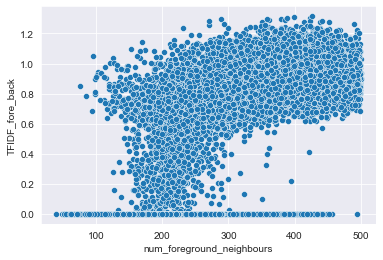

In [98]:
sns.set_style ("darkgrid")
sns.scatterplot(x="num_foreground_neighbours",
                y="TFIDF_fore_back",
                data=span_features_df)

# we'll also save span_features_df for reuse elsewhere
span_features_df.to_csv(embedding_output_fp.joinpath("span_features.csv"))

There seems to be some weak correlation between:
1. the number of foreground neighbours
2. the TF-IDF inspired value for a span, a value of 0 indicating that the term only appears in the background corpus

Our assumption is that at certain values this correlation indicates how 'domain-specific' a term is.
We should do some more tests to validate this.
For now, we'll assume that general background domain terms have:
* a low TF-IDF value, e.g., smaller than 0.5
* a relatively small number of foreground terms, e.g., cut-off at 200/500

In [87]:
min_TFIDF_value = 0.5
min_num_foreground_neighbours = 200

domain_terms = span_features_df[(span_features_df['TFIDF_fore_back'] >= min_TFIDF_value) & (span_features_df['num_foreground_neighbours'] >= min_num_foreground_neighbours)]
ood_terms = span_features_df[(span_features_df['TFIDF_fore_back'] < min_TFIDF_value) | (span_features_df['num_foreground_neighbours'] < min_num_foreground_neighbours)]


In [88]:
print(f"Examples of our {len(domain_terms)} AEC domain terms")
random.sample(domain_terms.index.tolist(), 10)

Examples of our 10026 AEC domain terms


['Appendix A : Key terms Appendix B : Performance of',
 'Vents',
 'metres N',
 'original 2003 Edition',
 'communal gates',
 'Fire - stopping',
 'the RISCAuthority Design Guide',
 'seconds',
 'junctions',
 'open air']

In [89]:
print(f"Examples of our {len(ood_terms)} general domain terms")
random.sample(ood_terms.index.tolist(), 10)

Examples of our 6415 general domain terms


['the risk assessment',
 'day period',
 'the risk - based approach',
 'February 2013',
 'the central circulatory system',
 'standardization',
 'the remuneration',
 'points b ) c )',
 'the designation',
 'quality management system']

Loading a pre-computed cluster dictionary from file.


Average number of terms per cluster: 2.1921333333333335


### 4 Suggesting similar terms for Uniclass

<div class="alert alert-block alert-info">
Here we predict (1) expansion candidates and (2) potential inflections (based on Levenshtein distance) for a given term. 
</div>


* We run our algorithm on all Uniclass terms to get a feel for the output we generate.

In [154]:
class ClusterAssignment:
    def __init__(self, pkl_model, embedder, unique_spans, standardised_clustering_data, phrase_cluster_dict, clusters_to_filter):
        """
        It's important to use the standardised clustering data here!
        """
        self.centroids, self.assignments = pickle.load(open(pkl_model, 'rb'))
        self.num_clusters = int(max(self.assignments) + 1)
        
        # set up sklearn for prediction
        cpu_centroids = np.nan_to_num(self.centroids, copy=True, nan=0.0, posinf=None, neginf=None)
        self.cpu_clusterer = KMeans(self.num_clusters, init=cpu_centroids, n_init=1, max_iter=1, tol=0)
        print("[Clustering] Initialising sklearn kMeans with 1 iteration on KMcuda outputs. This takes some time!")
        self.cpu_clusterer.fit(standardised_clustering_data)
        
        self.embedder = embedder
        self.unique_span_dict = dict(zip(unique_spans, standardised_clustering_data))
        self.cluster_dict = phrase_cluster_dict
        self.clusters_to_filter = clusters_to_filter
    

    def sklearn_assign(self, to_be_clustered: List[cluster_utils.ToBeClustered]) -> List[cluster_utils.ToBeClustered]:
        """
        Using SciKit Learn's CPU implementation of KMeans to assign cluster IDs to a span or list of spans.

        :param to_be_predicted: A `str` or `list` of strings for which a cluster ID will be computed.
        :return :   List of cluster IDs.
        """
        # Note: we try to avoid iteratively assigning clusters for each item in a list - don't think we parallelize more
        embeddings = [s.embedding for s in to_be_clustered]
        arrays = [np.ones([1, 768]).astype(np.float32) for _ in to_be_clustered]

        for i, e in enumerate(embeddings):
            arrays[i][0] = np.stack(e.squeeze())  # .astype(np.float16)

        assignments = []
        for arr in arrays:
            assignments.append(self.cpu_clusterer.predict(arr))

        for idx, assignment in enumerate(assignments):
            to_be_clustered[idx].cluster_id = str(int(assignment))
#             print(f"assigned ID: {str(int(assignment))}")
            to_be_clustered[idx].distance_to_centroid = np.sum(np.absolute(embeddings[idx]-self.centroids[assignment]))
            to_be_clustered[idx].all_neighbours = self.cluster_dict[str(int(assignment))]

        return to_be_clustered
    
    def get_top_neighbours(self, 
                           text_inputs : Union[List[str], str], 
                           cosine_sim_threshold: float = 0.7, 
                           top_k: int = 3,
                           return_non_aec=False):
        if type(text_inputs) == str:
            NON_AEC = False
            tbc = cluster_utils.ToBeClustered(text_inputs, embedder)
            [tbc] = self.sklearn_assign([tbc])
            if tbc.cluster_id in self.clusters_to_filter:
#                 print(f"Potentially non-AEC domain: {tbc.text}")
                NON_AEC = True
                
            if not return_non_aec and NON_AEC:
                return [], []
            else:
                neighbours, inflections = tbc.get_top_k_neighbours(self.unique_span_dict, cosine_sim_threshold, top_k)
                return neighbours, inflections
        else:
            tbcs = [cluster_utils.ToBeClustered(t, embedder) for t in text_inputs]
            tbcs = self.sklearn_assign(tbcs)
            neighbours = []
            inflections = []
            for tbc in tbcs:
                NON_AEC = False
                if tbc.cluster_id in self.clusters_to_filter:
#                     print(f"Potentially non-AEC domain: {tbc.text}")
                    NON_AEC = True
                if not return_non_aec and NON_AEC:
                    neighbours.append([])
                    inflections.append([])
                else:
                    n, i = tbc.get_top_k_neighbours(self.unique_span_dict, cosine_sim_threshold, top_k)
                    neighbours.append(n)
                    inflections.append(i)
            return neighbours, inflections
        

In [155]:
cluster_assigner = ClusterAssignment(cluster_model_to_use, embedder, unique_spans, standardised_clustering_data, phrase_cluster_dict, clusters_to_filter)

[Clustering] Initialising sklearn kMeans with 1 iteration on KMcuda outputs. This takes some time!


* some examples of assigning clusters and identifying neighbours for spans:

In [156]:
# example str input
example_string = "party wall"
neighbours, inflections = cluster_assigner.get_top_neighbours(example_string, cosine_sim_threshold=.7)
print("neighbours", neighbours)
print("inflections", inflections)

neighbours []
inflections ['party walls', 'Party walls']


In [157]:
# example list of str input
example_strings = ["a structural member", "control equipment"]
neighbours, inflections = cluster_assigner.get_top_neighbours(example_strings, 
                                                              cosine_sim_threshold=.7, 
                                                              return_non_aec=True)
for idx, (neighbour_list, inflection_list) in enumerate(zip(neighbours, inflections)):
    print(example_strings[idx])
    print("neighbours", neighbour_list)
    print("inflections", inflection_list)


a structural member
neighbours []
inflections ['the structural members']
control equipment
neighbours ['test equipment', 'electrical equipment']
inflections ['control equipment']


<div class="alert alert-block alert-info">
We read Uniclass terms from a .ttl file that we have previoulsy prepared.
</div>

In [158]:
def group_ttl_lines(text):
    groups = []
    current_group = []
    for idx, line in enumerate(text.split("\n")):
        if line == '':
            if current_group:
                groups.append(current_group)
            current_group = []
        else:
            current_group.append(line)
            if idx+1 == len(text.split("\n")):
                groups.append(current_group)
    return groups

In [159]:
def grab_uids_and_labels_with_definition(groups):
    uid_dict = {}
    for g in groups:
        if any([line.startswith('  skos:prefLabel') for line in g]):
            # only use group if a prefLabel exists
            pref_label = ''
            alt_labels = []
            definition = ''
            for line in g:
                if line.startswith('  skos:prefLabel'):
                    pref_label = line.split('"')[1]
                elif line.startswith('  skos:altLabel'):
                    labels = line.split('"')[1::2]
                    alt_labels += labels
                elif line.startswith('  skos:definition'):
                    definition = line.split('"')[1]

            if pref_label:
                uid = g[0].split()[0].split(":")[1]
                uid_dict[uid] = {'pref_label': pref_label, 
                                 'alt_labels': alt_labels,
                                 'definition': definition
                                }
    return uid_dict


In [160]:
def grab_nodes(vocab_name):
    processed_file = f"{vocab_name}.json"
    
    # check if file as processed before 
    NODES_LOADED = False
    if os.path.exists(processed_file):
        with open(processed_file) as f:
            graph_dict = json.load(f)
            
        NODES_LOADED = True
        print(f"Loaded nodes and neighbours for: {vocab_name}") 
    else: 
        print(f"Will have to grab nodes for: {vocab_name}")
    
        # compute the neighbours for each node
        graph_dict = {}
        
        print(f"Working on file: {vocab_name}")
        with open(vocab_name, 'r') as f:
            text =  f.read()
            
        groups = group_ttl_lines(text)
        print("Collecting nodes with definitions from dict")
        graph_dict = grab_uids_and_labels_with_definition(groups)
        
        # save the dictionary somewhere for reloading
        with open(processed_file, 'w') as f:
            json.dump(graph_dict, f)
    return graph_dict

In [161]:
uniclass_dict = grab_nodes("data/input/uniclass_2015.ttl")

Loaded nodes and neighbours for: data/input/uniclass_2015.ttl


In [237]:
len(uniclass_dict)

15020

In [256]:
uniclass_terms_in_text = {}
for content in foreground_corpus[0].all_contents:
    for uid, uiv in uniclass_dict.items():
        uterm = uiv['pref_label']
        if uterm.lower() in content.text.lower():  # lowercase everything to increase likelihood
            uniclass_terms_in_text[uid] = uiv


In [257]:
percentage = (len(uniclass_terms_in_text)/len(uniclass_dict)) * 100
print("Number of Uniclass terms found in the Approved Documents: {} ({:.2f}%)".format(len(uniclass_terms_in_text), percentage))

Number of Uniclass terms found in the Approved Documents: 553 (3.68%)


In [258]:
# pickle.dump(uniclass_terms_in_text, open("../identify_concepts/data/uniclass_terms_in_text.pkl", 'wb'))

Number of Uniclass terms found in the Approved Documents: 535 (3.56%)


In [255]:
random.sample(uniclass_terms_in_text, 10)

['Warehouses',
 'Safety harnesses',
 'Logo',
 'Abutments',
 'Keys',
 'Inset live fuel effect gas fires',
 'Swimming pool buildings',
 'Signalling',
 'Nursing homes',
 'Commercial kitchens']

* Feed the Uniclass labels to our predictor

In [163]:
expansion_candidates =  {}
for k, v in tqdm(uniclass_dict.items()):
    uniclass_label = v['pref_label']
    if uniclass_label:
        expansion_terms, inflections = cluster_assigner.get_top_neighbours(uniclass_label, 
                                                                           cosine_sim_threshold=.7,
                                                                           top_k=5,
                                                                           return_non_aec=False)
        aec_expansion_terms = [t for t in expansion_terms if t in domain_terms]
        ood_expansion_terms = [t for t in expansion_terms if t in ood_terms]
        aec_inflections = [t for t in inflections if t in domain_terms]
        ood_inflections = [t for t in inflections if t in ood_terms]
        
        
        expansion_candidates[uniclass_label] = {"AEC expansions": aec_expansion_terms,
                                                "AEC inflections": aec_inflections,
                                                "OOD expansions": ood_expansion_terms,
                                                "OOD inflections": ood_inflections}

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15020/15020 [21:14<00:00, 11.78it/s]


In [165]:
def print_expansion_candidates(expansion_candidates: Dict[str, str]):
    number_of_terms_with_expansion_candidates = 0
    for k, v in expansion_candidates.items():
        if v['AEC expansions'] or v['AEC inflections']:
            print(f"==========================\nTerm: {k}")
            print(f"AEC related: {v['AEC expansions']}")
            print(f"AEC inflections: {v['AEC inflections']}")
            print(f"OOD related: {v['OOD expansions']}")
            print(f"OOD inflections: {v['OOD inflections']}")
            number_of_terms_with_expansion_candidates += 1

    print("\n\n\nAmount of terms with candidates:\n{} ({:.2f}%)".format(
        number_of_terms_with_expansion_candidates,
        number_of_terms_with_expansion_candidates/len(expansion_candidates)*100))
    

In [166]:
print_expansion_candidates(expansion_candidates)

Term: Inspecting
AEC related: []
AEC inflections: ['Inspection']
OOD related: []
OOD inflections: []
Term: Pipe fitting
AEC related: []
AEC inflections: ['pipe fittings']
OOD related: []
OOD inflections: []
Term: Plumbing
AEC related: ['Plumbing fittings']
AEC inflections: []
OOD related: []
OOD inflections: []
Term: Remediation, repair and renovation
AEC related: ['remediation']
AEC inflections: []
OOD related: []
OOD inflections: []
Term: Remediation
AEC related: []
AEC inflections: ['remediation']
OOD related: []
OOD inflections: []
Term: Repair
AEC related: []
AEC inflections: ['Repair']
OOD related: []
OOD inflections: []
Term: Cold water and water treatment systems surveying
AEC related: ['the hot water system']
AEC inflections: ['a hot water system']
OOD related: []
OOD inflections: []
Term: Escalator and moving pavement systems surveying
AEC related: ['Escalators']
AEC inflections: []
OOD related: []
OOD inflections: []
Term: Sprinkler systems surveying
AEC related: ['Sprinkler

AEC related: ['Sound absorbers']
AEC inflections: []
OOD related: []
OOD inflections: []
Term: Bridge shock absorbers
AEC related: ['Sound absorbers']
AEC inflections: []
OOD related: []
OOD inflections: []
Term: Cavity wall ties
AEC related: ['Cavity walls']
AEC inflections: []
OOD related: []
OOD inflections: []
Term: Lateral restraint ties
AEC related: []
AEC inflections: ['lateral restraint']
OOD related: []
OOD inflections: []
Term: Tension straps
AEC related: []
AEC inflections: ['tension straps']
OOD related: []
OOD inflections: []
Term: Stainless steel stools
AEC related: ['Stainless Steels']
AEC inflections: []
OOD related: []
OOD inflections: []
Term: Carbon steel struts
AEC related: ['struts']
AEC inflections: []
OOD related: []
OOD inflections: []
Term: Trench struts
AEC related: ['struts']
AEC inflections: []
OOD related: []
OOD inflections: []
Term: Concrete track beds
AEC related: ['Concrete']
AEC inflections: []
OOD related: []
OOD inflections: []
Term: Hydraulic train 

AEC related: []
AEC inflections: ['Entrance hall']
OOD related: []
OOD inflections: []
Term: Decorative papers and roll coverings
AEC related: ['Decorative wall coverings']
AEC inflections: []
OOD related: []
OOD inflections: []
Term: Agglomerated composition cork tiles with polyvinyl chloride (PVC) wearing layer
AEC related: ['multi - skinned polycarbonate sheet products', 'rigid solid polycarbonate sheet products']
AEC inflections: []
OOD related: []
OOD inflections: []
Term: Cork-backed polyvinyl chloride (PVC) sheets
AEC related: ['rigid solid polycarbonate sheet products', 'multi - skinned polycarbonate sheet products']
AEC inflections: []
OOD related: []
OOD inflections: []
Term: Cork-backed polyvinyl chloride (PVC) tiles
AEC related: ['rigid solid polycarbonate sheet products']
AEC inflections: []
OOD related: []
OOD inflections: []
Term: Ethylene propylene diene monomer (EPDM) rubber tiles
AEC related: ['polyethylene sheet', 'polyethylene']
AEC inflections: []
OOD related: []
O

AEC inflections: []
OOD related: []
OOD inflections: []
Term: Hydraulic automation mechanisms
AEC related: ['Hydraulic design']
AEC inflections: []
OOD related: []
OOD inflections: []
Term: Emergency door release mechanisms
AEC related: ['automatic release mechanisms']
AEC inflections: ['an automatic release mechanism', 'An automatic release mechanism', 'Automatic release mechanism']
OOD related: []
OOD inflections: []
Term: Automatic sprinkler system indicator panels
AEC related: ['Automatic sprinkler systems', 'With sprinkler system', 'Design of sprinkler systems E3', 'The sprinkler water supplies', 'non - residential sprinkler systems']
AEC inflections: ['an automatic sprinkler system', 'The sprinkler system', 'a sprinkler system', 'the sprinkler system']
OOD related: []
OOD inflections: []
Term: Automatic sprinkler pump control panels
AEC related: ['Automatic sprinkler systems', 'With sprinkler system', 'The sprinkler water supplies', 'Design of sprinkler systems E3', 'non - reside

Term: Radioactive wastewater treatment systems
AEC related: ['a wastewater treatment system']
AEC inflections: ['wastewater treatment systems', 'wastewater treatment system']
OOD related: []
OOD inflections: []
Term: Surface water tank systems
AEC related: []
AEC inflections: ['surface water drainage systems']
OOD related: []
OOD inflections: []
Term: Rainwater harvesting systems
AEC related: ['rainwater drainage systems']
AEC inflections: []
OOD related: []
OOD inflections: []
Term: Wastewater storage, treatment and disposal systems
AEC related: ['wastewater treatment systems']
AEC inflections: ['a wastewater treatment system', 'wastewater treatment system']
OOD related: []
OOD inflections: []
Term: Prefabricated inlet works systems
AEC related: ['prefabricated components']
AEC inflections: []
OOD related: []
OOD inflections: []
Term: Odour control systems
AEC related: []
AEC inflections: ['smoke control systems', 'heat control systems', 'Smoke control system']
OOD related: []
OOD inf

In [167]:
[x for x in domain_terms if x in ood_terms]

[]

* Our own list of terms of interest

* TODO TODO TODO TODO TODO TODO:
  * add lowercase term results
  * do not process acronyms

In [168]:
terms_of_interest = ['Timber frame floors and roofs',  'EPS',  'Water services',  'Subsystems',  'External thermal insulation composite system with rendering ',  'Smoke and fire-stopping',  'Timber baseboards',  'PV panels',  'Ceramic slates',  'Vertical smoke strip curtains',  'Hardwood deck boards',  'Roof type',  'Flat roof ',  'Aluminium external panels',  'Material',  'Ethylene propylene (EP) damp-proof courses and cavity trays',  'Vertical smoke curtains',  'Light-gauge steel floors and roofs',  'Fibre-cement',  'Fibre-reinforced cement boards',  'Services',  'Fire alarm systems',  'HVAC equipment',  'Covering',  'Mineral wool insulation',  'Components',  'Roof structure - flat',  'CLT',  'Aluminium cassette panels',  'Fibre-reinforced cement sheets',  'Weathering steel cassette panels',  'Clay roofing tiles',  'Batteries',  'Natural stone',  'Bitumen-based damp-proof courses and cavity trays',  'Board suspended ceiling systems',  'Green roofs/gardens',  'Maintenance access',  'Softwood baseboards',  'Polyurethane (PUR) foam boards',  'Sheet panels',  'Glulam',  'Flexible sheet for waterproofing',  'Panelled and framed modular systems',  'Vertical active fire curtain barriers',  'Gypsum core boards',  'Barriers',  'Light steel roof framing systems',  'Natural stone panels',  'Timber sheet panels',  'Mineral wool wire-reinforced mattress cavity barriers',  'Structural frame',  'Aluminium internal panels',  'Roof diaphragm',  'Structural connectors',  'Timber',  'Roof windows',  'Reinforced concrete',  'Ceramic tiles',  'LWSF - Light weight steel-frame',  'Panel of steel-wires with incorporated thermal insulation',  'Water tightness',  'Structural',  'Structural insulated panel systems',  'Cold-applied roofing membrane adhesive damp-proof course joint sealers',  'Mineral fibre slab insulation',  'Cross-laminated timber (CLT) panelled modules',  'Membranes',  'Ceiling and soffit systems',  'Green roof',  'Skylights',  'Extruded polyethylene (PE) foam boards',  'Plain tile roofing systems',  'Wood-based panels',  'Blue roof',  'Insulated damp-proof courses',  'Interfacial',  'Light-gauge steel frame panels',  'Aluminium structures',  'Timber board panels',  'Bitumen membrane shingles',  'Mastic asphalt (MA) damp-proof courses',  'Deck frame',  'ICT',  'Gypsum baseboards',  'Flexible stone wool mat insulation',  'Pitched roof ',  'Fire insulating caps',  'Active smoke barriers',  'Fibre cement slate roofing systems',  'Steel structures',  'Photovoltaic devices',  'Structural insulated panel (SIP) modules',  'Mineral wool slab insulation',  'XPS',  'Sound proofing',  'Ceiling cassettes',  'Highlighted relevant item',  'Hardboards',  'Intumescent sleeved mineral wool cavity fire barriers',  'Thermal insulation',  'Solar photovoltaic modules',  'Wood structures',  'Aluminium-faced aluminium core panels',  'Steel deck',  'P-DfMA Standards Database',  'Rain drainage',  'Polymeric damp-proof courses',  'Active Roof',  'Flexible intumescent gap seals',  'Bonded sheets',  'Underlays for discontinuous roofing',  'Bitumen sheets',  'Prefabricated framed and panelled structures',  'Panels',  'Composite',  'Active roof',  'Sealants',  'Building elements',  'Hardwood baseboards',  'Light gauge steel frame',  'Mineral wool flexible insulation',  'Energy storage',  'Air tightness',  'Passive roof',  'Ceramic panels',  'Vapour control layer',  'Mineral wool',  'Energy generation and storage',  'Softwood deck boards',  'Ceramic fibre fire-stopping',  'Intumescent linear gap seals',  'Gypsum plasterboards',  'Oriented strand boards',  'Non-loadbearing',  'Wood-based boards',  'Roof-mounted photovoltaic',  'Tapered insulation',  'Solar thermal systems',  'Carbon steel insulating sandwich panels',  'Fire detection',  'LVL',  'Fibre-cement slates',  'Insulation',  'Cold roof ',  'Self-supporting double skin metal faced insulating panels',  'Composite panels',  'Carbon steel framed vertical bar and rail panels',  'Mineral wool fire-stopping',  'Warm roof ',  'Damp-proof courses and cavity trays',  'Flexible plasterboards',  'Superstructure',  'Prefabricated building units ',  'Aluminium composite material (ACM) panels',  'Natural slates',  'Fire-fighting systems',  'Mechanical services',  'Bitumen membrane shingle roofing systems',  'Wood laminate strips and boards',  'Ceramic',  'PIR',  'Plastics membranes',  'Extruded polystyrene (XPS) boards',  'Composite lightweight panels',  'Bitumen membrane',  'Rainwater harvesting',  'Coated woven glass fibre cloth flexible cavity barriers',  'Wood fibre boards',  'Polyisocyanurate (PIR) foam boards',  'Timber lining boards',  'Pre-fabricated wood-based loadbearing stressed skin panels',  'External wall',  'Fully bonded pre applied flexible sheet for water proofing ',  'Plywood desk',  'Load bearing',  'Concrete roofing tiles',  'Expanded polystyrene (EPS) boards',  'Timber structures']

In [169]:
term_expansion_candidates =  {}
for term in tqdm(terms_of_interest):
#     term = term if term.isupper() else term.lower() # remove capitalisation if not an abbreviation
    expansion_terms, inflections = cluster_assigner.get_top_neighbours(term, 
                                                                       cosine_sim_threshold=.7,
                                                                       top_k=5,
                                                                       return_non_aec=False)

    aec_expansion_terms = [t for t in expansion_terms if t in domain_terms]
    ood_expansion_terms = [t for t in expansion_terms if t in ood_terms]
    aec_inflections = [t for t in inflections if t in domain_terms]
    ood_inflections = [t for t in inflections if t in ood_terms]
    term_expansion_candidates[term] = {"AEC expansions": aec_expansion_terms,
                                       "AEC inflections": aec_inflections,
                                       "OOD expansions": ood_expansion_terms,
                                       "OOD inflections": ood_inflections}

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 179/179 [00:13<00:00, 13.43it/s]


In [170]:
print_expansion_candidates(term_expansion_candidates)

Term: EPS
AEC related: ['EPC']
AEC inflections: []
OOD related: []
OOD inflections: []
Term: Water services
AEC related: ['Water supply']
AEC inflections: ['the Water Supply']
OOD related: []
OOD inflections: []
Term: External thermal insulation composite system with rendering 
AEC related: ['insulating core panels']
AEC inflections: []
OOD related: []
OOD inflections: []
Term: Smoke and fire-stopping
AEC related: ['fire - stopping']
AEC inflections: ['Fire - stopping', 'fire - stopped']
OOD related: []
OOD inflections: []
Term: Timber baseboards
AEC related: ['Timber cladding']
AEC inflections: []
OOD related: []
OOD inflections: []
Term: Roof type
AEC related: ['Roof']
AEC inflections: []
OOD related: []
OOD inflections: []
Term: Flat roof 
AEC related: []
AEC inflections: ['Flat roof', 'flat roof', 'flat roofs']
OOD related: []
OOD inflections: []
Term: Aluminium external panels
AEC related: ['Aluminium alloy']
AEC inflections: []
OOD related: []
OOD inflections: []
Term: Fibre-ceme

* Identify candidate mappings based on overlap in expansion candidates and inflections

In [198]:
for k1, v1 in term_expansion_candidates.items():
    potential_uniclass_matches = []
    for k2, v2 in expansion_candidates.items(): 
        if any([candidate for candidate in v1['AEC expansions'] + v1['AEC inflections'] if (candidate in v2['AEC expansions'] or candidate in v2['AEC inflections'])]):
            potential_uniclass_matches.append(k2)
    if potential_uniclass_matches:
        print(f"Match?===============\nBRE: {k1}\nUniclass: {potential_uniclass_matches}\n")

Match?===============
BRE: Water services
Uniclass: ['Water supply']

Match?===============
BRE: External thermal insulation composite system with rendering 
Uniclass: ['Carbon steel insulating sandwich panels', 'Cellular glass insulation boards']

Match?===============
BRE: Smoke and fire-stopping
Uniclass: ['Smoke and fire-stopping']

Match?===============
BRE: Timber baseboards
Uniclass: ['Timber baseboards']

Match?===============
BRE: Aluminium external panels
Uniclass: ['Aluminium alloy bollards', 'Aluminium alloy hinged bollards', 'Aluminium alloy telescopic bollards', 'Aluminium curtain wall frame sections', 'Aluminium extruded bars and rods', 'Aluminium extruded precision profiles', 'Aluminium structural sections', 'Aluminium extruded tubes', 'Aluminium alloy posts', 'Aluminium alloy rails', 'Aluminium support rails', 'Aluminium carrier rails', 'Aluminium structural beams', 'Aluminium structural columns', 'Aluminium wires', 'Aluminium cold-formed planks', 'Aluminium edging sec

Match?===============
BRE: Skylights
Uniclass: ['Skylights']

Match?===============
BRE: Extruded polyethylene (PE) foam boards
Uniclass: ['High-density polyethylene (PE-HD) geonets', 'Chlorinated polyethylene (PE-C) geomembranes', 'High-density polyethylene (PE-HD) studded sheets', 'High-density polyethylene (PE-HD) sheets', 'Low-density polyethylene (PE-LD) sheets', 'Extruded polyethylene (PE) foam joint fillers', 'Extruded polyethylene (PE) foam boards', 'Ethylene propylene diene monomer (EPDM) rubber tiles', 'Ethylene propylene diene monomer (EPDM) gaskets', 'Ethylene propylene diene monomer (EPDM)-coated expanded polyethylene (PE) foam profile fillers', 'Expanded polyethylene (PE) foam profile fillers', 'Expanded polyethylene (PE) foam strips', 'Recycled polyethylene (PE) inspection chambers', 'Micro-perforated polyethylene sheet', 'Ethylene tetraflourethylene (ETFE) roof systems']

Match?===============
BRE: Aluminium structures
Uniclass: ['Aluminium nails', 'Aluminium cold drawn

Match?===============
BRE: Extruded polystyrene (XPS) boards
Uniclass: ['Heavy-duty polystyrene geocell boards', 'Heavy-duty polystyrene geocell sheets', 'High-impact polystyrene (HIPS) studded sheets', 'Extruded polystyrene (XPS) boards']

Match?===============
BRE: Concrete roofing tiles
Uniclass: ['Concrete expanding agents', 'Concrete foaming agents', 'Concretes', 'Concrete panelled modules', 'Concrete-framed modules', 'Concrete shaft cover slabs', 'Concrete shaft landing slabs', 'Concrete rails', 'Concrete beams', 'Concrete pier caps', 'Concrete bund units', 'Concrete duct units', 'Concrete base and foundation products', 'Concrete bases for fence posts', 'Concrete floating slab foundations', 'Concrete ground beams', 'Concrete pocket foundations', 'Concrete flooring and decking products', 'Concrete hollow core slabs', 'Concrete kentledge blocks', 'Concrete solid slabs', 'Concrete columns', 'Concrete bridge pedestals', 'Concrete piles', 'Concrete pile caps', 'Concrete sheet piles', 

### Grab acronyms (naive SPaR based approach)

In [230]:

# Grab the potential acronyms for spans
span_acronym_dict = {}
for span in tqdm(domain_terms):
    span_acronym_dict[span] = []
    for content in foreground_corpus[0].all_contents:
        if span in content.text:
            # now we start looking for 
            text_splits = content.text.split(span)
            for subsequent_text in text_splits[1:]:
                potential_abbrev = re.match(r"^\s+\([A-Z]+\)", subsequent_text)
                if potential_abbrev:
                    potential_abbrev = potential_abbrev.group(0).split('(', 1)[1][:-1]
                    span_acronym_dict[span].append(potential_abbrev)
    span_acronym_dict[span] = list(set(span_acronym_dict[span]))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8063/8063 [00:10<00:00, 793.92it/s]


In [231]:
# turn around; {acronym: span}
acronym_dict = {}
for span, acronym_list in span_acronym_dict.items():
    if acronym_list:
        acronym_list = list(set(acronym_list))
        for acronym in acronym_list:
            if acronym not in acronym_dict:
                acronym_dict[acronym] = [span]
            else:
                acronym_dict[acronym].append(span)
        

In [232]:
acronym_dict

{'PAS': ['ecification', 'Specification'],
 'GSIUR': ['Regulations 1998'],
 'HSE': ['Regulations 2000',
  'water systems',
  'Safety Executive',
  'Health and Safety Executive'],
 'PE': ['Polyethylene', 'polyethylene'],
 'DN': ['pipe'],
 'DCLG': ['land', 'Local Government', 'England', 'ment'],
 'PP': ['Polypropylene'],
 'BCB': ['Control Body',
  'the building control body',
  'Building control body',
  'building control body',
  'Building Control Body'],
 'SRHRV': ['ventilator',
  'single room heat recovery ventilator',
  'a single room heat recovery ventilator'],
 'MVHR': ['blocks', 'heat recovery'],
 'WC': ['sets'],
 'TFA': ['the total floor area'],
 'LRV': ['Light reflectance value'],
 'BER': ['Building CO2 Emission Rate', 'CO2 Emission Rate'],
 'TER': ['CO2 Emission Rate',
  'the Target CO2 Emission Rate',
  'Target CO2 Emission Rate'],
 'DER': ['CO2 Emission Rate', 'the Dwelling CO2 Emission Rate'],
 'EPC': ['energy performance certificate'],
 'TFEE': ['Target Fabric Energy Efficie